In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Оценка стоимости кварталов

In [2]:
blocks_gdf = gdf = pd.read_pickle("../data/blocks.pickle")
# blocks_gdf = gdf = gpd.read_parquet('../data/blocks_maks.parquet')
blocks_gdf.columns

Index(['geometry', 'residential', 'business', 'recreation', 'industrial',
       'transport', 'special', 'agriculture', 'land_use', 'share',
       ...
       'capacity_prison', 'count_prison', 'capacity_landfill',
       'count_landfill', 'capacity_plant_nursery', 'count_plant_nursery',
       'capacity_greenhouse_complex', 'count_greenhouse_complex',
       'capacity_warehouse', 'count_warehouse'],
      dtype='object', length=136)

In [3]:
# from blocksnet.analysis.morphotypes import get_strelka_morphotypes

# blocks_df = get_strelka_morphotypes(blocks_gdf)
# blocks_gdf = blocks_gdf.join(blocks_df[['morphotype']], how='left')
# blocks_df.head()

In [4]:
# cadastr_land = gpd.read_parquet('data/spb_land_cad.parquet')
cadastr_blocks = gpd.read_parquet('../data/spb_bloks_price.parquet')
cadastr_blocks.head()

cadastralDistrictsCode                                   readable_address  \
0                      78  Санкт-Петербург, город Зеленогорск, Решетников...   
1                      78  г.Санкт-Петербург, город Зеленогорск, Решетник...   
2                      78  Санкт-Петербург, город Зеленогорск, Красавица,...   
3                      78  Санкт-Петербург, город Зеленогорск, Решетников...   
4                      78  Санкт-Петербург, город Зеленогорск, Решетников...   

    cost_value  cost_index land_record_category_type  \
0  10833260.98   5846.3362  Земли населенных пунктов   
1   6533139.72   5444.2831  Земли населенных пунктов   
2     16395.97   1366.3305  Земли населенных пунктов   
3   8425371.37   5513.9865  Земли населенных пунктов   
4  11430710.60   5715.3553  Земли населенных пунктов   

               permitted_use_established_by_document  specified_area  \
0  для размещения индивидуального жилого дома (ин...          1852.0   
1  для размещения индивидуального жилого дома (ин...          1200.0   
2   Для размещения объектов коммунального  хозяйства            12.0   
3  Для размещения индивидуального (одноквартирног...          1528.0   
4  для размещения индивидуального жилого дома (ин...          2000.0   

                                            geometry  
0  POLYGON ((3306132.351 8453357.197, 3306131.265...  
1  POLYGON ((3306613.198 8453876.707, 3306609.831...  
2  POLYGON ((3311932.709 8453466.264, 3311927.608...  
3  POLYGON ((3306341.721 8454345.055, 3306347.49 ...  
4  POLYGON ((3306583.407 8453412.704, 3306580.412...

In [5]:
cadastr_blocks['log_cost_index'] = np.log1p(cadastr_blocks['cost_index'])

In [6]:
# blocks_gdf['log_population'] = np.log1p(blocks_gdf['population'])

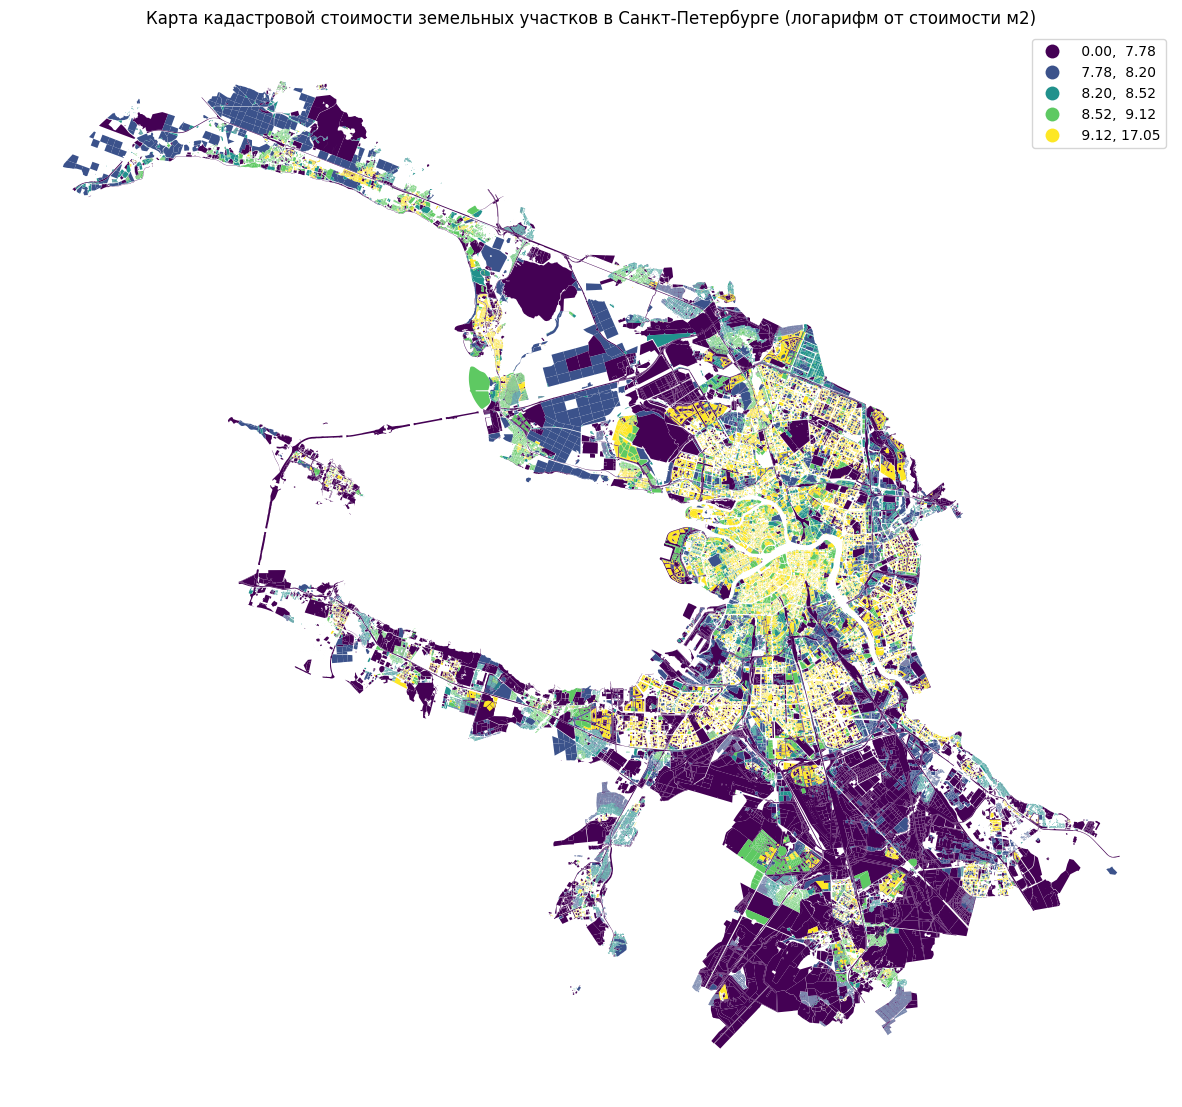

In [7]:
# Картируем лог-цену
cadastr_blocks.plot(
    column='log_cost_index',
    scheme='quantiles',
    legend=True,
    figsize=(15,15),
    cmap='viridis'
).set_axis_off()
plt.title('Карта кадастровой стоимости земельных участков в Санкт-Петербурге (логарифм от стоимости м2)')

plt.show()

In [8]:
import geopandas as gpd

# — 1. Клонируем оригиналы, чтобы не портить исходники
blocks = blocks_gdf.copy()
cad    = cadastr_blocks.copy()

# — 2. Приводим к единому CRS (он нужен для корректных площадей)
if blocks.crs != cad.crs:
    cad = cad.to_crs(blocks.crs)

# — 3. Считаем полную площадь cadastral-полигонов
cad['cad_area'] = cad.geometry.area

# — 4. Явно добавляем в blocks колонку block_id из индекса
blocks['block_id'] = blocks.index

# — 5. Пересечение кварталов и кадастра
inter = gpd.overlay(
    blocks[['block_id', 'geometry']],
    cad   [['cost_value', 'cad_area', 'geometry']],
    how='intersection'
)

# — 6. Площадь каждого куска пересечения
inter['int_area'] = inter.geometry.area

# — 7. Вклады стоимости пропорционально площади
inter['cost_contrib'] = inter['cost_value'] * inter['int_area'] / inter['cad_area']

# — 8. Суммируем для каждого квартала
block_costs = (
    inter
    .groupby('block_id', as_index=False)['cost_contrib']
    .sum()
    .rename(columns={'cost_contrib':'total_cost_value'})
)

# — 9. Мерджим обратно в blocks, заполняем пропуски нулями
blocks = blocks.merge(block_costs, on='block_id', how='left')
blocks['total_cost_value'] = blocks['total_cost_value'].fillna(0)

# — 10. При желании убираем служебный block_id (или возвращаем исходный индекс)
blocks = blocks.drop(columns=['block_id'])
blocks


/tmp/ipykernel_31580/3193496010.py:18: UserWarning: `keep_geom_type=True` in overlay resulted in 64 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  inter = gpd.overlay(


geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...     0.000000   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...     0.099000   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...     1.000000   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...     0.729125   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...     0.454375   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...     0.937805   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...     0.125516   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...     0.000000   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...     0.404385   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...     0.692846   

      business  recreation  industrial  transport  special  agriculture  \
0          0.0    0.000000    0.000000   1.000000      0.0     0.000000   
1          0.0    0.079912    0.000000   0.401072      0.0     0.417018   
2          0.0    0.000000    0.000000   0.000000      0.0     0.000000   
3          0.0    0.270875    0.000000   0.000000      0.0     0.000000   
4          0.0    0.000000    0.000000   0.144935      0.0     0.399984   
...        ...         ...         ...        ...      ...          ...   
9363       0.0    0.000000    0.000000   0.062195      0.0     0.000000   
9364       0.0    0.266734    0.000000   0.607750      0.0     0.000000   
9365       0.0    0.763388    0.000000   0.231754      0.0     0.000000   
9366       0.0    0.000000    0.471607   0.124008      0.0     0.000000   
9367       0.0    0.000000    0.000000   0.197534      0.0     0.000000   

                 land_use     share  ...  count_prison  capacity_landfill  \
0       LandUse.TRANSPORT  1.000000  ...           0.0                0.0   
1     LandUse.AGRICULTURE  0.417018  ...           0.0                0.0   
2     LandUse.RESIDENTIAL  1.000000  ...           0.0                0.0   
3     LandUse.RESIDENTIAL  0.729125  ...           0.0                0.0   
4     LandUse.RESIDENTIAL  0.454375  ...           0.0                0.0   
...                   ...       ...  ...           ...                ...   
9363  LandUse.RESIDENTIAL  0.937805  ...           0.0                0.0   
9364    LandUse.TRANSPORT  0.607750  ...           0.0                0.0   
9365   LandUse.RECREATION  0.763388  ...           0.0                0.0   
9366   LandUse.INDUSTRIAL  0.471607  ...           0.0                0.0   
9367  LandUse.RESIDENTIAL  0.692846  ...           0.0                0.0   

      count_landfill  capacity_plant_nursery  count_plant_nursery  \
0                0.0                     0.0                  0.0   
1                0.0                     0.0                  0.0   
2                0.0                     0.0                  0.0   
3                0.0                     0.0                  0.0   
4                0.0                    30.0                  1.0   
...              ...                     ...                  ...   
9363             0.0                     0.0                  0.0   
9364             0.0                     0.0                  0.0   
9365             0.0                     0.0                  0.0   
9366             0.0                     0.0                  0.0   
9367             0.0                     0.0                  0.0   

      capacity_greenhouse_complex  count_greenhouse_complex  \
0                             0.0                       0.0   
1                             0.0                       0.0   
2                             0.0                       0.0   
3                             0.0                       0.0   
4                             0.0                       0.0   
...                           ...                       ...   
9363                          0.0                       0.0   
9364                   

In [9]:
# 1. Если CRS географический (deg), переведём в метрический (например, Меркатор)
if blocks.crs.is_geographic:
    blocks = blocks.to_crs(epsg=3857)

# 2. Считаем площадь каждого квартала в м²
blocks['site_area'] = blocks.geometry.area

# 3. Считаем цену за квадратный метр
blocks['price_per_sqm'] = blocks['total_cost_value'] / blocks['site_area']
# blocks = blocks.drop(columns=['site_area'])
# 4. (Опционально) уберём бесконечные и NaN
blocks.loc[~blocks['price_per_sqm'].replace([np.inf, -np.inf], np.nan).notna(), 'price_per_sqm'] = 0
blocks = blocks.to_crs(epsg=32636)
blocks.head()
# Результат: в blocks['price_per_sqm'] — стоимость одного квадрата метра для каждого квартала


geometry  residential  business  \
0  POLYGON ((349424.859 6631180.891, 349424.751 6...     0.000000       0.0   
1  POLYGON ((352083.617 6633950.146, 352240.448 6...     0.099000       0.0   
2  POLYGON ((346700.642 6618453.176, 346681.107 6...     1.000000       0.0   
3  POLYGON ((347043.363 6618261.219, 347042.608 6...     0.729125       0.0   
4  POLYGON ((354879.039 6618859.116, 354845.405 6...     0.454375       0.0   

   recreation  industrial  transport  special  agriculture  \
0    0.000000         0.0   1.000000      0.0     0.000000   
1    0.079912         0.0   0.401072      0.0     0.417018   
2    0.000000         0.0   0.000000      0.0     0.000000   
3    0.270875         0.0   0.000000      0.0     0.000000   
4    0.000000         0.0   0.144935      0.0     0.399984   

              land_use     share  ...  count_landfill  capacity_plant_nursery  \
0    LandUse.TRANSPORT  1.000000  ...             0.0                     0.0   
1  LandUse.AGRICULTURE  0.417018  ...             0.0                     0.0   
2  LandUse.RESIDENTIAL  1.000000  ...             0.0                     0.0   
3  LandUse.RESIDENTIAL  0.729125  ...             0.0                     0.0   
4  LandUse.RESIDENTIAL  0.454375  ...             0.0                    30.0   

   count_plant_nursery  capacity_greenhouse_complex  count_greenhouse_complex  \
0                  0.0                          0.0                       0.0   
1                  0.0                          0.0                       0.0   
2                  0.0                          0.0                       0.0   
3                  0.0                          0.0                       0.0   
4                  1.0                          0.0                       0.0   

   capacity_warehouse  count_warehouse  total_cost_value      site_area  \
0                 0.0              0.0      0.000000e+00       0.032316   
1                 0.0              0.0      1.292022e+08  137101.088247   
2                 0.0              0.0      1.859462e+08   95239.084434   
3                 0.0              0.0      1.897886e+08  125919.330984   
4                 0.0              0.0      3.733097e+08  169860.164494   

   price_per_sqm  
0       0.000000  
1     942.386203  
2    1952.414484  
3    1507.223306  
4    2197.747147  

[5 rows x 139 columns]

In [10]:
blocks['log_total_price'] = np.log1p(blocks['total_cost_value'])
blocks['log_price'] = np.log1p(blocks['price_per_sqm'])

count    9368.000000
mean       17.462873
std         5.086053
min         0.000000
25%        17.498282
50%        18.743291
75%        19.909712
max        23.881662
Name: log_total_price, dtype: float64


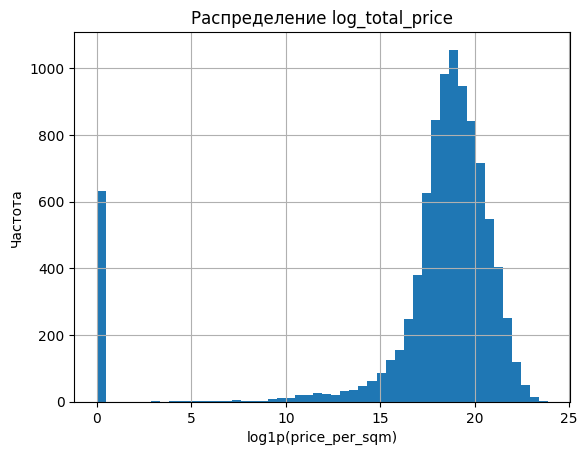

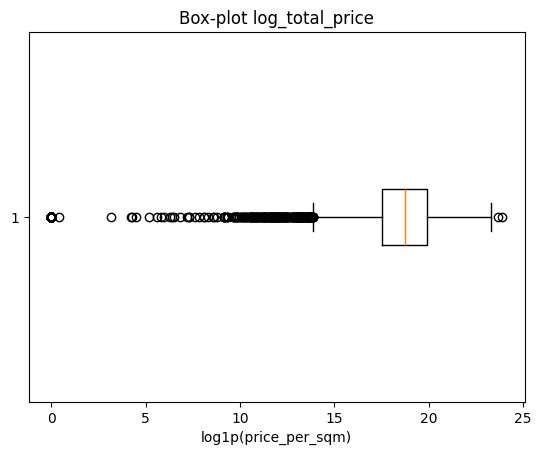

In [11]:
# Быстрая статистика
print(blocks['log_total_price'].describe())

# Гистограмма
plt.figure()
blocks['log_total_price'].hist(bins=50)
plt.xlabel('log1p(price_per_sqm)')
plt.ylabel('Частота')
plt.title('Распределение log_total_price')
plt.show()

# Box-plot
plt.figure()
plt.boxplot(blocks['log_total_price'].dropna(), vert=False)
plt.xlabel('log1p(price_per_sqm)')
plt.title('Box-plot log_total_price')
plt.show()


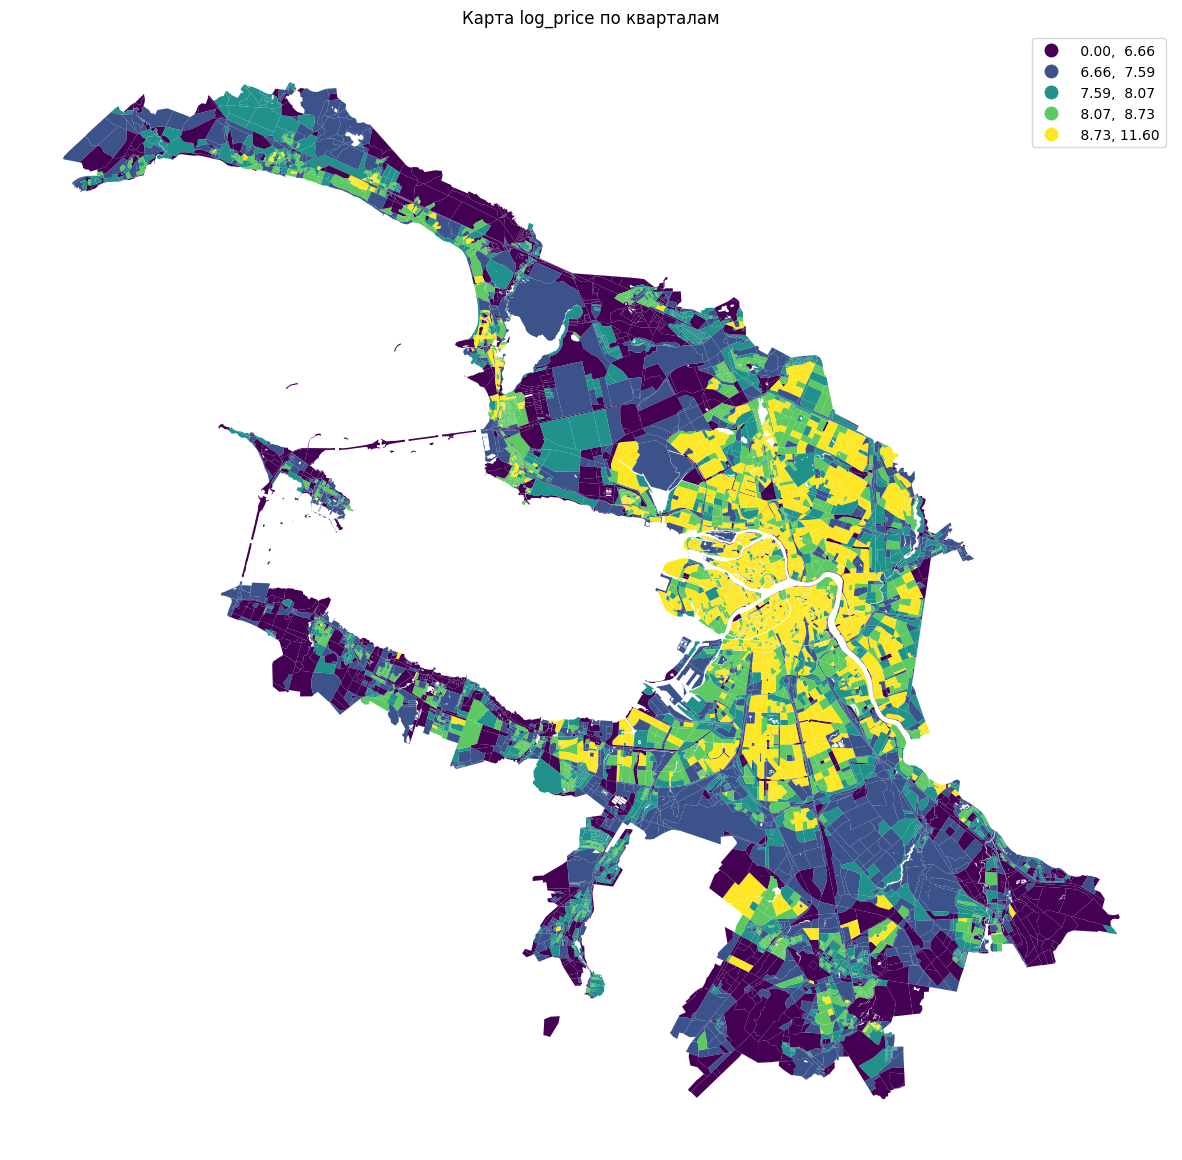

In [12]:
# Картируем лог-цену
blocks.plot(
    column='log_price',
    scheme='quantiles',
    legend=True,
    figsize=(15,15),
    cmap='viridis'
).set_axis_off()
plt.title('Карта log_price по кварталам')

plt.show()



In [13]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# blocks['log_std'] = scaler.fit_transform(
#     blocks[['log_price']]
# )

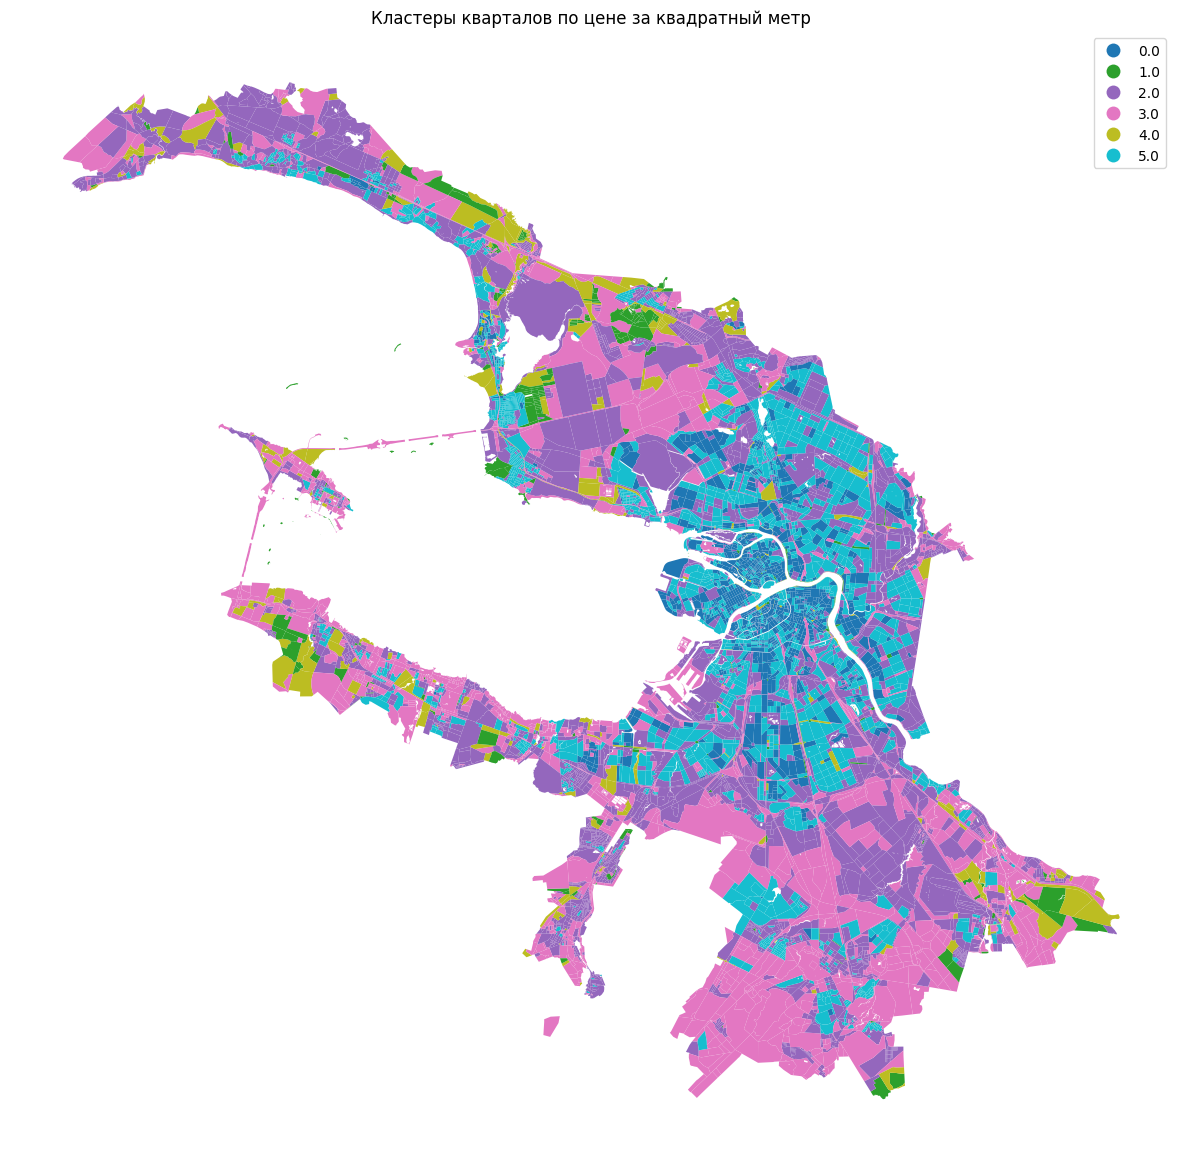

In [14]:
from sklearn.cluster import KMeans

# Берём только ненулевые и не NaN
X = blocks[['log_price']].dropna()

kmeans = KMeans(n_clusters=6, random_state=0)
blocks.loc[X.index, 'cluster'] = kmeans.fit_predict(X)

# Визуализируем
blocks.plot(
    column='cluster',
    categorical=True,
    legend=True,
    figsize=(15,15)
).set_axis_off()
plt.title('Кластеры кварталов по цене за квадратный метр')
plt.show()


In [15]:
# Собираем все имена колонок, которые начинаются на 'capacity'
cols_to_drop = [col for col in blocks.columns if col.startswith('capacity')]
blocks = blocks.drop(columns=cols_to_drop)
cols_to_drop = [col for col in blocks.columns if col.startswith('count')]
blocks = blocks.drop(columns='cluster')
# Удаляем их сразу все
blocks = blocks.drop(columns=cols_to_drop)

blocks.columns

Index(['geometry', 'residential', 'business', 'recreation', 'industrial',
       'transport', 'special', 'agriculture', 'land_use', 'share',
       'footprint_area', 'build_floor_area', 'living_area', 'non_living_area',
       'population', 'total_cost_value', 'site_area', 'price_per_sqm',
       'log_total_price', 'log_price'],
      dtype='object')

In [16]:
blocks['land_use'] = (
    blocks['land_use']
    .astype(str)
    .str.replace(r'^LandUse\.', '', regex=True)
)

In [17]:
blocks

geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...     0.000000   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...     0.099000   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...     1.000000   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...     0.729125   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...     0.454375   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...     0.937805   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...     0.125516   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...     0.000000   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...     0.404385   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...     0.692846   

      business  recreation  industrial  transport  special  agriculture  \
0          0.0    0.000000    0.000000   1.000000      0.0     0.000000   
1          0.0    0.079912    0.000000   0.401072      0.0     0.417018   
2          0.0    0.000000    0.000000   0.000000      0.0     0.000000   
3          0.0    0.270875    0.000000   0.000000      0.0     0.000000   
4          0.0    0.000000    0.000000   0.144935      0.0     0.399984   
...        ...         ...         ...        ...      ...          ...   
9363       0.0    0.000000    0.000000   0.062195      0.0     0.000000   
9364       0.0    0.266734    0.000000   0.607750      0.0     0.000000   
9365       0.0    0.763388    0.000000   0.231754      0.0     0.000000   
9366       0.0    0.000000    0.471607   0.124008      0.0     0.000000   
9367       0.0    0.000000    0.000000   0.197534      0.0     0.000000   

         land_use     share  footprint_area  build_floor_area   living_area  \
0       TRANSPORT  1.000000        0.000000          0.000000      0.000000   
1     AGRICULTURE  0.417018       69.018103         69.018103      0.000000   
2     RESIDENTIAL  1.000000     5853.863274       6106.759644   4197.188633   
3     RESIDENTIAL  0.729125     4214.828165       4375.483259   3033.795607   
4     RESIDENTIAL  0.454375    13392.846325      31242.324144  20860.965881   
...           ...       ...             ...               ...           ...   
9363  RESIDENTIAL  0.937805     4360.962708      21549.418762   9911.577637   
9364    TRANSPORT  0.607750    14963.573074      73149.192154      0.000000   
9365   RECREATION  0.763388       25.673922         25.673922      0.000000   
9366   INDUSTRIAL  0.471607    12973.889317      52737.331333      0.000000   
9367  RESIDENTIAL  0.692846     8400.633087      50804.762238  33728.387695   

      non_living_area  population  total_cost_value      site_area  \
0            0.000000         0.0      0.000000e+00       0.032316   
1           69.018103         0.0      1.292022e+08  137101.088247   
2         1909.571011       109.0      1.859462e+08   95239.084434   
3         1341.687653        77.0      1.897886e+08  125919.330984   
4        10381.358263       431.0      3.733097e+08  169860.164494   
...               ...         ...               ...            ...   
9363     11637.841125       199.0      2.190559e+08   16802.384600   
9364     73149.192154         0.0      3.747208e+08   47637.956433   
9365        25.673922         0.0      1.718310e+08   64487.699525   
9366     52737.331333         0.0      2.592440e+08   42988.399080   
9367     17076.374542      1121.0      1.501452e+09   74469.973136   

      price_per_sqm  log_total_price  log_price  
0          0.000000         0.000000   0.000000  
1        942.386203        18.676889   6.849476  
2       1952.414484        19.040968   7.577334  
3       1507.223306        19.061421   7.318688  
4       2197.747147        19.737919   7.695643  
...             ...              ...        ...  
9363   13037.194136        19.204838   9.475638  
9364    7866.012468        19.741692   8.970434  
9365    2664.554605        18.962022   7.

In [18]:
# blocks.to_file('blocks2.geojson', driver='GeoJSON')

## Дополнитльные метрики

In [19]:
# blocks = gdf = gpd.read_file('/Users/mvin/Code/blocksnet/examples/data/blocks2/blocks2.geojson')

In [20]:
from blocksnet.analysis.indicators import calculate_density_indicators 

blocks_df = calculate_density_indicators(blocks[[
    'site_area',
    'footprint_area',
    'build_floor_area',
    'living_area'
]])
blocks_df

2025-07-03 15:16:22.835 | WARNING  | blocksnet.analysis.indicators.density.schemas:_before_validate:19 - The non_living_area is not in columns, restoring


site_area  footprint_area  build_floor_area   living_area  \
0          0.032316        0.000000          0.000000      0.000000   
1     137101.088247       69.018103         69.018103      0.000000   
2      95239.084434     5853.863274       6106.759644   4197.188633   
3     125919.330984     4214.828165       4375.483259   3033.795607   
4     169860.164494    13392.846325      31242.324144  20860.965881   
...             ...             ...               ...           ...   
9363   16802.384600     4360.962708      21549.418762   9911.577637   
9364   47637.956433    14963.573074      73149.192154      0.000000   
9365   64487.699525       25.673922         25.673922      0.000000   
9366   42988.399080    12973.889317      52737.331333      0.000000   
9367   74469.973136     8400.633087      50804.762238  33728.387695   

      non_living_area       fsi       gsi       mxi         l          osr  \
0            0.000000  0.000000  0.000000       NaN       NaN          inf   
1           69.018103  0.000503  0.000503  0.000000  1.000000  1985.451134   
2         1909.571011  0.064120  0.061465  0.687302  1.043202    14.637095   
3         1341.687653  0.034748  0.033472  0.693362  1.038117    27.815100   
4        10381.358263  0.183930  0.078846  0.667715  2.332762     5.008184   
...               ...       ...       ...       ...       ...          ...   
9363     11637.841125  1.282521  0.259544  0.459946  4.941436     0.577344   
9364     73149.192154  1.535523  0.314110  0.000000  4.888484     0.446681   
9365        25.673922  0.000398  0.000398  0.000000  1.000000  2510.797791   
9366     52737.331333  1.226781  0.301800  0.000000  4.064882     0.569132   
9367     17076.374542  0.682218  0.112806  0.663882  6.047730     1.300456   

      share_living  share_non_living  
0              NaN               NaN  
1         0.000000          1.000000  
2         0.716995          0.326207  
3         0.719791          0.318326  
4         1.557620          0.775142  
...            ...               ...  
9363      2.272796          2.668640  
9364      0.000000          4.888484  
9365      0.000000          1.000000  
9366      0.000000          4.064882  
9367      4.014982          2.032749  

[9368 rows x 12 columns]

In [21]:
blocks.loc[:, blocks_df.columns] = blocks_df
blocks

geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...     0.000000   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...     0.099000   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...     1.000000   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...     0.729125   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...     0.454375   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...     0.937805   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...     0.125516   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...     0.000000   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...     0.404385   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...     0.692846   

      business  recreation  industrial  transport  special  agriculture  \
0          0.0    0.000000    0.000000   1.000000      0.0     0.000000   
1          0.0    0.079912    0.000000   0.401072      0.0     0.417018   
2          0.0    0.000000    0.000000   0.000000      0.0     0.000000   
3          0.0    0.270875    0.000000   0.000000      0.0     0.000000   
4          0.0    0.000000    0.000000   0.144935      0.0     0.399984   
...        ...         ...         ...        ...      ...          ...   
9363       0.0    0.000000    0.000000   0.062195      0.0     0.000000   
9364       0.0    0.266734    0.000000   0.607750      0.0     0.000000   
9365       0.0    0.763388    0.000000   0.231754      0.0     0.000000   
9366       0.0    0.000000    0.471607   0.124008      0.0     0.000000   
9367       0.0    0.000000    0.000000   0.197534      0.0     0.000000   

         land_use     share  ...  price_per_sqm  log_total_price  log_price  \
0       TRANSPORT  1.000000  ...       0.000000         0.000000   0.000000   
1     AGRICULTURE  0.417018  ...     942.386203        18.676889   6.849476   
2     RESIDENTIAL  1.000000  ...    1952.414484        19.040968   7.577334   
3     RESIDENTIAL  0.729125  ...    1507.223306        19.061421   7.318688   
4     RESIDENTIAL  0.454375  ...    2197.747147        19.737919   7.695643   
...           ...       ...  ...            ...              ...        ...   
9363  RESIDENTIAL  0.937805  ...   13037.194136        19.204838   9.475638   
9364    TRANSPORT  0.607750  ...    7866.012468        19.741692   8.970434   
9365   RECREATION  0.763388  ...    2664.554605        18.962022   7.888167   
9366   INDUSTRIAL  0.471607  ...    6030.557529        19.373280   8.704761   
9367  RESIDENTIAL  0.692846  ...   20161.849128        21.129699   9.911597   

           fsi       gsi       mxi         l          osr  share_living  \
0     0.000000  0.000000       NaN       NaN          inf           NaN   
1     0.000503  0.000503  0.000000  1.000000  1985.451134      0.000000   
2     0.064120  0.061465  0.687302  1.043202    14.637095      0.716995   
3     0.034748  0.033472  0.693362  1.038117    27.815100      0.719791   
4     0.183930  0.078846  0.667715  2.332762     5.008184      1.557620   
...        ...       ...       ...       ...          ...           ...   
9363  1.282521  0.259544  0.459946  4.941436     0.577344      2.272796   
9364  1.535523  0.314110  0.000000  4.888484     0.446681      0.000000   
9365  0.000398  0.000398  0.000000  1.000000  2510.797791      0.000000   
9366  1.226781  0.301800  0.000000  4.064882     0.569132      0.000000   
9367  0.682218  0.112806  0.663882  6.047730     1.300456      4.014982   

      share_non_living  
0                  NaN  
1             1.000000  
2             0.326207  
3             0.318326  
4             0.775142  
...                ...  
9363          2.668640  
9364          4.888484  
9365          1.000000  
9366          4.064882  
9367          2.032749  

[9368 rows x 27 columns]

In [22]:
from blocksnet.analysis.morphotypes import get_strelka_morphotypes


blocks_df = get_strelka_morphotypes(blocks)
blocks_df

l       fsi       mxi                morphotype
0     0.000000  0.000000  0.000000                       NaN
1     1.000000  0.000503  0.000000  low-rise non-residential
2     1.043202  0.064120  0.687302    individual residential
3     1.038117  0.034748  0.693362    individual residential
4     2.332762  0.183930  0.667715            low-rise model
...        ...       ...       ...                       ...
9363  4.941436  1.282521  0.459946                  mid-rise
9364  4.888484  1.535523  0.000000  mid-rise non-residential
9365  1.000000  0.000398  0.000000  low-rise non-residential
9366  4.064882  1.226781  0.000000  mid-rise non-residential
9367  6.047730  0.682218  0.663882                  mid-rise

[9368 rows x 4 columns]

In [23]:
blocks.loc[:, blocks_df.columns] = blocks_df
blocks

geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...     0.000000   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...     0.099000   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...     1.000000   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...     0.729125   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...     0.454375   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...     0.937805   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...     0.125516   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...     0.000000   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...     0.404385   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...     0.692846   

      business  recreation  industrial  transport  special  agriculture  \
0          0.0    0.000000    0.000000   1.000000      0.0     0.000000   
1          0.0    0.079912    0.000000   0.401072      0.0     0.417018   
2          0.0    0.000000    0.000000   0.000000      0.0     0.000000   
3          0.0    0.270875    0.000000   0.000000      0.0     0.000000   
4          0.0    0.000000    0.000000   0.144935      0.0     0.399984   
...        ...         ...         ...        ...      ...          ...   
9363       0.0    0.000000    0.000000   0.062195      0.0     0.000000   
9364       0.0    0.266734    0.000000   0.607750      0.0     0.000000   
9365       0.0    0.763388    0.000000   0.231754      0.0     0.000000   
9366       0.0    0.000000    0.471607   0.124008      0.0     0.000000   
9367       0.0    0.000000    0.000000   0.197534      0.0     0.000000   

         land_use     share  ...  log_total_price  log_price       fsi  \
0       TRANSPORT  1.000000  ...         0.000000   0.000000  0.000000   
1     AGRICULTURE  0.417018  ...        18.676889   6.849476  0.000503   
2     RESIDENTIAL  1.000000  ...        19.040968   7.577334  0.064120   
3     RESIDENTIAL  0.729125  ...        19.061421   7.318688  0.034748   
4     RESIDENTIAL  0.454375  ...        19.737919   7.695643  0.183930   
...           ...       ...  ...              ...        ...       ...   
9363  RESIDENTIAL  0.937805  ...        19.204838   9.475638  1.282521   
9364    TRANSPORT  0.607750  ...        19.741692   8.970434  1.535523   
9365   RECREATION  0.763388  ...        18.962022   7.888167  0.000398   
9366   INDUSTRIAL  0.471607  ...        19.373280   8.704761  1.226781   
9367  RESIDENTIAL  0.692846  ...        21.129699   9.911597  0.682218   

           gsi       mxi         l          osr  share_living  \
0     0.000000  0.000000  0.000000          inf           NaN   
1     0.000503  0.000000  1.000000  1985.451134      0.000000   
2     0.061465  0.687302  1.043202    14.637095      0.716995   
3     0.033472  0.693362  1.038117    27.815100      0.719791   
4     0.078846  0.667715  2.332762     5.008184      1.557620   
...        ...       ...       ...          ...           ...   
9363  0.259544  0.459946  4.941436     0.577344      2.272796   
9364  0.314110  0.000000  4.888484     0.446681      0.000000   
9365  0.000398  0.000000  1.000000  2510.797791      0.000000   
9366  0.301800  0.000000  4.064882     0.569132      0.000000   
9367  0.112806  0.663882  6.047730     1.300456      4.014982   

      share_non_living                morphotype  
0                  NaN                       NaN  
1             1.000000  low-rise non-residential  
2             0.326207    individual residential  
3             0.318326    individual residential  
4             0.775142            low-rise model  
...                ...                       ...  
9363          2.668640                  mid-rise  
9364          4.888484  mid-rise non-residential  
9365          1.000000  low-rise non-residential  
9366          4.064882  mid-rise non-residential  
9367          2.032749                  mid-rise  

In [24]:
from blocksnet.relations import generate_adjacency_graph

adjacency_graph = generate_adjacency_graph(blocks)

/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
2025-07-03 15:16:25.426 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_nodes:10 - Generating nodes
2025-07-03 15:16:25.430 | INFO     | blocksnet.relations.adjacency.core:_generate_adjacency_edges:15 - Generating edges
2025-07-03 15:16:26.542 | SUCCESS  | blocksnet.relations.adjacency.core:generate_adjacency_graph:38 - Adjacency graph successfully generated: 9368 nodes, 27879 edges


In [25]:
import pandas as pd

accessibility_matrix = pd.read_pickle('../data/acc_mx.pickle')
# accessibility_matrix = pd.read_pickle('../data/accessibility_matrix.pickle')
accessibility_matrix.head()

/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


0         1          2           3        4         5          6     \
0   0.0000  58.15625  74.187500   76.937500  66.8125   80.5000   92.18750   
1  56.2500   0.00000  99.687500  102.375000  88.1250   76.1250  113.43750   
2  74.5000  96.50000   0.000000    5.347656  74.0000  118.8125   92.06250   
3  77.2500  99.25000   5.347656    0.000000  76.7500  121.5625   90.12500   
4  70.1875  90.56250  82.375000   85.125000   0.0000  110.5000   35.53125   

       7         8         9     ...      9358      9359      9360      9361  \
0  66.56250  65.68750  106.8750  ...   70.0000   72.1875   72.0000   73.3125   
1  89.43750  88.56250   96.3125  ...   65.6250   67.7500   67.6875   69.0000   
2  64.43750  63.56250  134.5000  ...  108.3125  110.4375  110.3750  111.6875   
3  67.18750  66.31250  137.2500  ...  111.0625  113.1875  113.0625  114.3750   
4  45.15625  44.28125   89.8750  ...  100.0000  102.1250  102.0000  103.3125   

       9362      9363      9364      9365      9366      9367  
0   73.2500   74.0000   75.5000   83.1875   75.0000   73.2500  
1   68.8750   69.6875   71.1875   78.8125   70.6875   68.8750  
2  111.5625  112.3750  113.8125  121.5000  113.3750  111.5625  
3  114.3125  115.0625  116.5625  124.2500  116.1250  114.3125  
4  103.2500  104.0000  105.5000  113.1875  105.0000  103.2500  

[5 rows x 9368 columns]

In [26]:
from blocksnet.analysis.accessibility import area_accessibility

area_acc_df = area_accessibility(accessibility_matrix, blocks)
area_acc_df

area_accessibility
0             114.184718
1             113.847998
2             145.884534
3             148.543184
4             132.691062
...                  ...
9363           92.742199
9364           94.557197
9365          100.500833
9366           92.488100
9367           93.766946

[9368 rows x 1 columns]

In [27]:
blocks= blocks.join(area_acc_df)


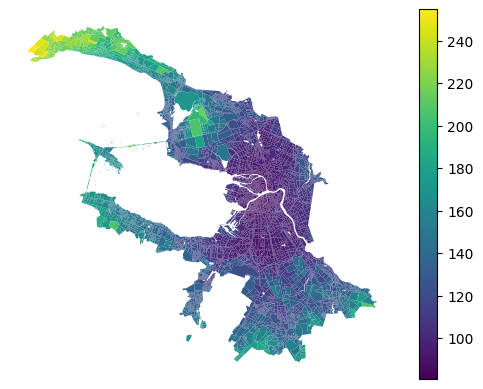

In [28]:
blocks.plot(column='area_accessibility', legend=True).set_axis_off()

In [29]:
# 1. Выведем все dtypes
print(blocks.dtypes)

# 2. Отберём «чисто» категориальные (object / category)
cat_cols = blocks.select_dtypes(include=['object','category']).columns.tolist()
print("Категориальные по dtype:", cat_cols)

# 3. Часто к категориальным относят и числовые колонки с малым числом уникальных значений.
#    Например, если уникальных значений меньше 10:
low_cardinality = [
    col for col in blocks.select_dtypes(include=['int64','float64']).columns
    if blocks[col].nunique() < 10
]
print("Возможно категориальные по низкой кардинальности:", low_cardinality)


geometry              geometry
residential            float64
business               float64
recreation             float64
industrial             float64
transport              float64
special                float64
agriculture            float64
land_use                object
share                  float64
footprint_area         float64
build_floor_area       float64
living_area            float64
non_living_area        float64
population             float64
total_cost_value       float64
site_area              float64
price_per_sqm          float64
log_total_price        float64
log_price              float64
fsi                    float64
gsi                    float64
mxi                    float64
l                      float64
osr                    float64
share_living           float64
share_non_living       float64
morphotype              object
area_accessibility     float64
dtype: object
Категориальные по dtype: ['land_use', 'morphotype']
Возможно категориальные по низкой к

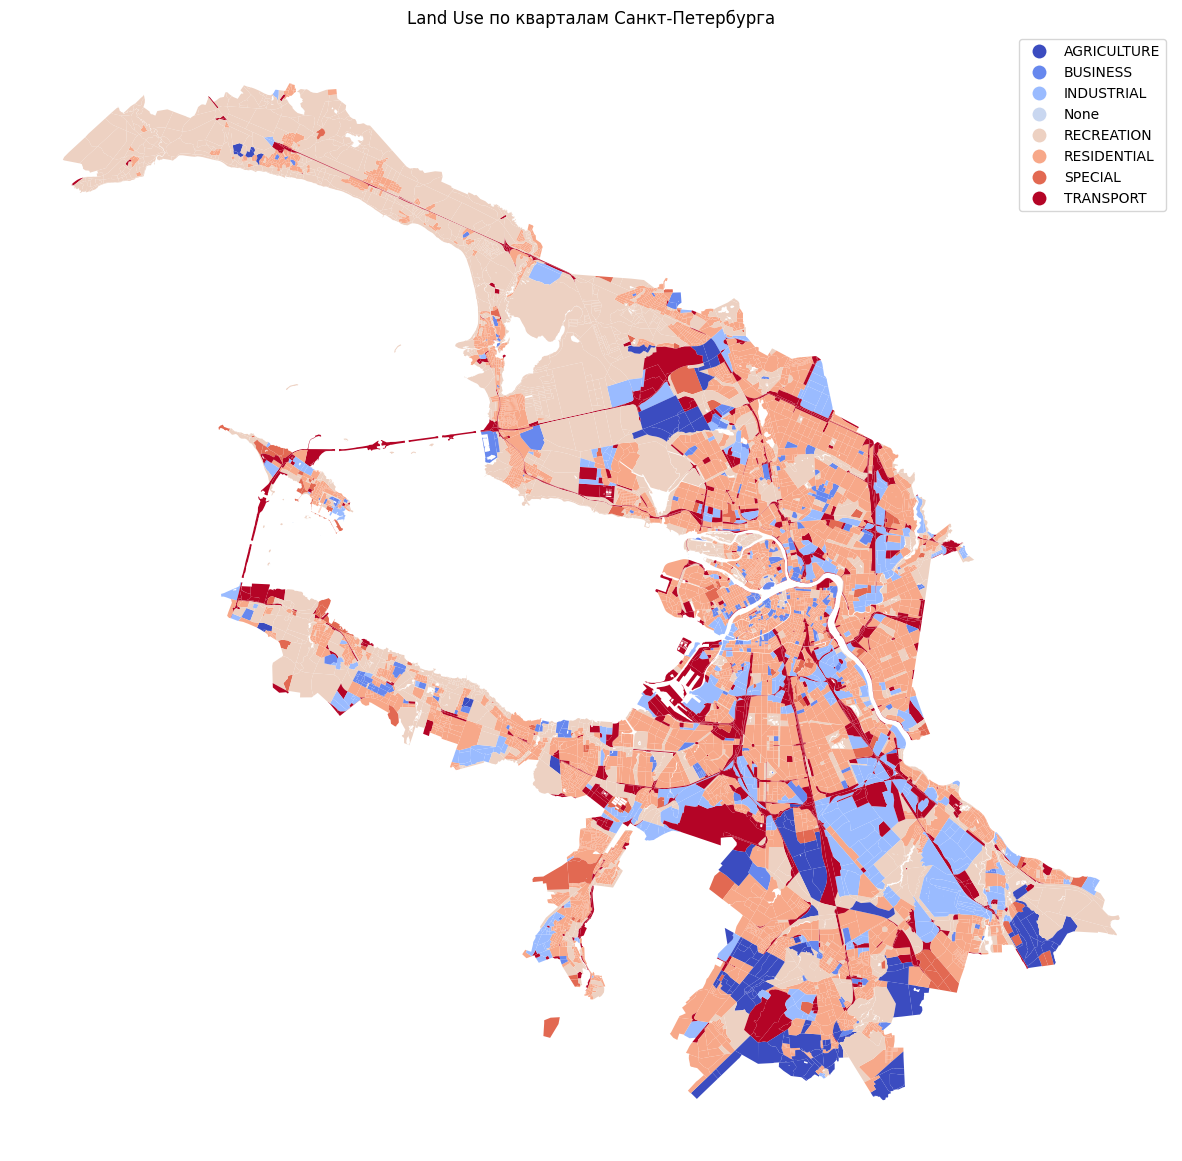

In [30]:
# Картируем лог-цену
blocks.plot(
    column='land_use',
    legend=True,
    figsize=(15,15),
    cmap='coolwarm'
).set_axis_off()
plt.title('Land Use по кварталам Санкт-Петербурга')

plt.show()

In [31]:
import pandas as pd

# 1. Отбираем числовые столбцы и фильтруем
num = blocks.select_dtypes(include=['number'])
num = num[num['log_price'] > 1]

# 2. Считаем count + статистики
agg_stats = num.agg(['count', 'min', 'max', 'mean', 'median', 'std']).T

# 3. Переименовываем столбцы
agg_stats.index.name = 'Variable'
agg_stats = agg_stats.rename(columns={
    'count':  'Count',
    'min':    'Min',
    'max':    'Max',
    'mean':   'Mean',
    'median': 'Median',
    'std':    'SD'
})

# 4. Приводим Count к int
agg_stats['Count'] = agg_stats['Count'].astype(int)

# 5. Округляем остальные метрики
for col in ['Min','Max','Mean','Median','SD']:
    agg_stats[col] = agg_stats[col].round(2)

# 6. Настраиваем глобальный формат для float
pd.options.display.float_format = '{:,.2f}'.format

# 7. Показываем результат
agg_stats


/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Count   Min               Max           Mean  \
Variable                                                           
residential          8703  0.00              1.00           0.51   
business             8703  0.00              1.00           0.03   
recreation           8703  0.00              1.00           0.18   
industrial           8703  0.00              1.00           0.05   
transport            8703  0.00              1.00           0.18   
special              8703  0.00              1.00           0.01   
agriculture          8703  0.00              1.00           0.01   
share                8692  0.00              1.00           0.85   
footprint_area       8703  0.00        818,787.73      11,961.95   
build_floor_area     8703  0.00      1,653,097.76      45,627.97   
living_area          8703  0.00        658,823.73      19,658.91   
non_living_area      8703  0.00      1,653,097.76      25,969.06   
population           8703  0.00         31,406.00         627.84   
total_cost_value     8703  0.00 23,532,814,433.13 502,822,240.97   
site_area            8703  0.00     14,029,413.94     156,571.35   
price_per_sqm        8703  1.81        109,577.36       4,661.64   
log_total_price      8703  0.00             23.88          18.73   
log_price            8703  1.03             11.60           7.81   
fsi                  8703  0.00              9.15           0.41   
gsi                  8703  0.00              0.95           0.12   
mxi                  8703  0.00              0.90           0.32   
l                    8703  0.00             26.40           2.24   
osr                  8703  0.05               inf            inf   
share_living         7238  0.00             17.16           1.20   
share_non_living     7238  0.10             17.92           1.49   
area_accessibility   8703 80.85            254.73         120.82   

                           Median               SD  
Variable                                            
residential                  0.68             0.43  
business                     0.00             0.15  
recreation                   0.00             0.33  
industrial                   0.00             0.19  
transport                    0.07             0.28  
special                      0.00             0.10  
agriculture                  0.00             0.11  
share                        0.91             0.16  
footprint_area           3,202.12        25,274.92  
build_floor_area         4,531.03       109,162.36  
living_area                821.89        58,427.54  
non_living_area          2,432.77        63,525.40  
population                  27.00         2,041.91  
total_cost_value   159,418,687.90 1,027,144,862.61  
site_area               54,277.13       380,519.40  
price_per_sqm            2,742.54         5,890.93  
log_total_price             18.89             2.12  
log_price                    7.92             1.33  
fsi                          0.10             0.65  
gsi                          0.08             0.13  
mxi                          0.34             0.30  
l                            1.25             2.69  
osr                          8.78              NaN  
share_living                 0.70             1.76  
share_non_living             1.00             1.34  
area_accessibility         117.18            28.72

In [32]:
blocks_default = blocks.copy()

In [33]:
# blocks = blocks_default[blocks_default['land_use'] == 'RESIDENTIAL'].copy()

In [34]:
blocks = blocks[blocks['log_total_price'] > 0].copy()
blocks = blocks.reset_index(drop=True)
blocks

geometry  residential  \
0     POLYGON ((352083.617 6633950.146, 352240.448 6...         0.10   
1     POLYGON ((346700.642 6618453.176, 346681.107 6...         1.00   
2     POLYGON ((347043.363 6618261.219, 347042.608 6...         0.73   
3     POLYGON ((354879.039 6618859.116, 354845.405 6...         0.45   
4     POLYGON ((347215.933 6646341.789, 347245.429 6...         0.11   
...                                                 ...          ...   
8753  POLYGON ((346635.461 6647492.048, 346473.426 6...         0.94   
8754  POLYGON ((346361.221 6647603.446, 346328.072 6...         0.13   
8755  POLYGON ((344109.285 6649134.367, 344000.209 6...         0.00   
8756  POLYGON ((346323.488 6649497.386, 346199.573 6...         0.40   
8757  POLYGON ((346670.461 6649890.747, 346543.309 6...         0.69   

      business  recreation  industrial  transport  special  agriculture  \
0         0.00        0.08        0.00       0.40     0.00         0.42   
1         0.00        0.00        0.00       0.00     0.00         0.00   
2         0.00        0.27        0.00       0.00     0.00         0.00   
3         0.00        0.00        0.00       0.14     0.00         0.40   
4         0.00        0.00        0.77       0.06     0.00         0.00   
...        ...         ...         ...        ...      ...          ...   
8753      0.00        0.00        0.00       0.06     0.00         0.00   
8754      0.00        0.27        0.00       0.61     0.00         0.00   
8755      0.00        0.76        0.00       0.23     0.00         0.00   
8756      0.00        0.00        0.47       0.12     0.00         0.00   
8757      0.00        0.00        0.00       0.20     0.00         0.00   

         land_use  share  ...  log_price  fsi  gsi  mxi    l      osr  \
0     AGRICULTURE   0.42  ...       6.85 0.00 0.00 0.00 1.00 1,985.45   
1     RESIDENTIAL   1.00  ...       7.58 0.06 0.06 0.69 1.04    14.64   
2     RESIDENTIAL   0.73  ...       7.32 0.03 0.03 0.69 1.04    27.82   
3     RESIDENTIAL   0.45  ...       7.70 0.18 0.08 0.67 2.33     5.01   
4      INDUSTRIAL   0.77  ...       9.06 1.00 0.25 0.00 4.00     0.75   
...           ...    ...  ...        ...  ...  ...  ...  ...      ...   
8753  RESIDENTIAL   0.94  ...       9.48 1.28 0.26 0.46 4.94     0.58   
8754    TRANSPORT   0.61  ...       8.97 1.54 0.31 0.00 4.89     0.45   
8755   RECREATION   0.76  ...       7.89 0.00 0.00 0.00 1.00 2,510.80   
8756   INDUSTRIAL   0.47  ...       8.70 1.23 0.30 0.00 4.06     0.57   
8757  RESIDENTIAL   0.69  ...       9.91 0.68 0.11 0.66 6.05     1.30   

      share_living  share_non_living                morphotype  \
0             0.00              1.00  low-rise non-residential   
1             0.72              0.33    individual residential   
2             0.72              0.32    individual residential   
3             1.56              0.78            low-rise model   
4             0.00              4.00  mid-rise non-residential   
...            ...               ...                       ...   
8753          2.27              2.67                  mid-rise   
8754          0.00              4.89  mid-rise non-residential   
8755          0.00              1.00  low-rise non-residential   
8756          0.00              4.06  mid-rise non-residential   
8757          4.01              2.03                  mid-rise   

      area_accessibility  
0                 113.85  
1                 145.88  
2                 148.54  
3                 132.69  
4                  99.16  
...                  ...  
8753               92.74  
8754               94.56  
8755              100.50  
8756               92.49  
8757               93.77  

[8758 rows x 29 columns]

In [35]:
list(blocks.columns)

['geometry',
 'residential',
 'business',
 'recreation',
 'industrial',
 'transport',
 'special',
 'agriculture',
 'land_use',
 'share',
 'footprint_area',
 'build_floor_area',
 'living_area',
 'non_living_area',
 'population',
 'total_cost_value',
 'site_area',
 'price_per_sqm',
 'log_total_price',
 'log_price',
 'fsi',
 'gsi',
 'mxi',
 'l',
 'osr',
 'share_living',
 'share_non_living',
 'morphotype',
 'area_accessibility']

In [36]:
# blocks['id'] = blocks.index
# blocks2 = blocks[['id', 'geometry']].copy()
# blocks2.explore()

In [37]:
# import libpysal
# from esda.moran import Moran, Moran_Local
# import matplotlib.pyplot as plt
# from splot.esda import lisa_cluster

# # 1) Подготовка: spatial weights
# # Если у вас уже есть w1 (Rook или Queen), используем его, иначе:
# w1 = libpysal.weights.Queen.from_dataframe(blocks_default)
# # или: w1 = libpysal.weights.Rook.from_dataframe(blocks)
# w1.transform = 'r'   # row-standardization

# # 2) Извлекаем вектор переменной
# y = blocks_default['log_total_price'].values

# # 3) Глобальный индекс Морена
# moran_global = Moran(y, w1)
# print("Global Moran’s I:",     round(moran_global.I,3))
# print("p-value (normal):",     round(moran_global.p_norm,3))
# print("z-score (normal):",     round(moran_global.z_norm,3))
# print("p-value (permut.):",    round(moran_global.p_sim,3))
# print("z-score (permut.):",    round(moran_global.z_sim,3))

# # 4) Локальный индекс Морена
# lisa = Moran_Local(y, w1)

# # 5) Добавляем результаты в GeoDataFrame
# blocks_default['lisa_I']   = lisa.Is          # локальные значения I
# blocks_default['lisa_p']   = lisa.p_sim       # p-values по перестановкам
# blocks_default['lisa_q']   = lisa.q           # квадранты (1=HH, 2=LH, 3=LL, 4=HL)
# blocks_default['lisa_sig'] = lisa.p_sim < 0.05

# # 6) Визуализация LISA-кластеров
# fig, ax = plt.subplots(1, figsize=(15, 15))
# # splot умеет сам раскрасить по четырём кластерам
# lisa_cluster(lisa, blocks_default, p=0.05, ax=ax)
# ax.set_title("LISA-кластеризация (p<0.05)")
# ax.axis('off')
# plt.show()


# CatBoost

/tmp/ipykernel_31580/1599791626.py:24: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w1 = Queen.from_dataframe(blocks)      # w1.weights — все 1
/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 142 disconnected components.
 There are 115 islands with ids: 332, 333, 455, 876, 1173, 1335, 1353, 2424, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3076, 3077, 3078, 3079, 3080, 3081, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3118, 3119, 3120, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3162, 3168, 3189, 3253, 3500, 3509, 3510, 3622, 3746, 3747, 3748, 3749, 3793, 3863, 3942, 3943, 3973, 3979, 3980, 3997, 3998, 3999, 4000, 4174, 4175, 4176, 4416, 4417, 4589, 4590, 4657, 4658, 4659, 4660, 4661, 4662, 4663, 4664, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721, 4722, 47

('WARNING: ', 332, ' is an island (no neighbors)')
('WARNING: ', 333, ' is an island (no neighbors)')
('WARNING: ', 455, ' is an island (no neighbors)')
('WARNING: ', 876, ' is an island (no neighbors)')
('WARNING: ', 1173, ' is an island (no neighbors)')
('WARNING: ', 1335, ' is an island (no neighbors)')
('WARNING: ', 1353, ' is an island (no neighbors)')
('WARNING: ', 2424, ' is an island (no neighbors)')
('WARNING: ', 3056, ' is an island (no neighbors)')
('WARNING: ', 3057, ' is an island (no neighbors)')
('WARNING: ', 3058, ' is an island (no neighbors)')
('WARNING: ', 3059, ' is an island (no neighbors)')
('WARNING: ', 3060, ' is an island (no neighbors)')
('WARNING: ', 3061, ' is an island (no neighbors)')
('WARNING: ', 3062, ' is an island (no neighbors)')
('WARNING: ', 3076, ' is an island (no neighbors)')
('WARNING: ', 3077, ' is an island (no neighbors)')
('WARNING: ', 3078, ' is an island (no neighbors)')
('WARNING: ', 3079, ' is an island (no neighbors)')
('WARNING: ', 30

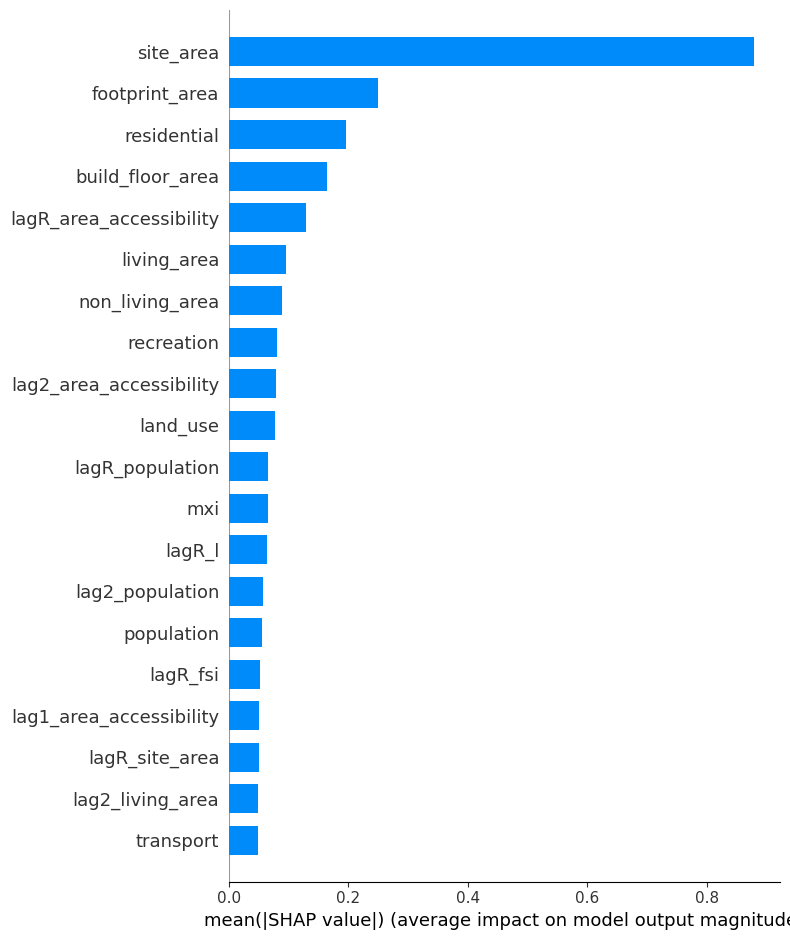

<Figure size 640x480 with 0 Axes>

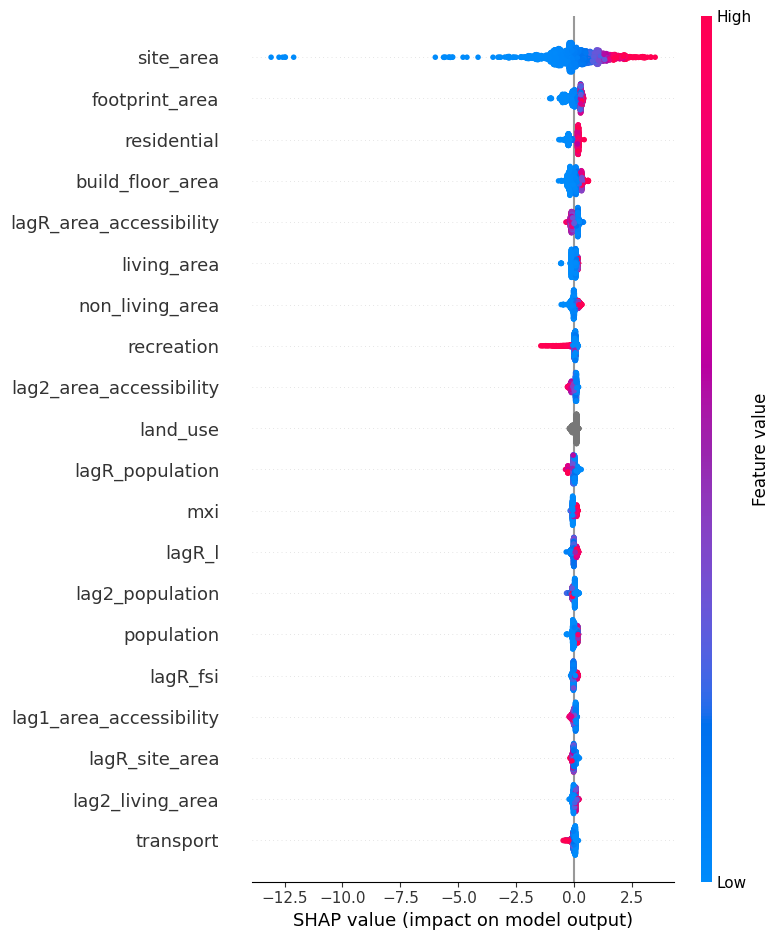

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool
import shap, matplotlib.pyplot as plt
from libpysal.weights import Queen, higher_order, DistanceBand, lag_spatial

# --- 0. Исходные данные ---

feature_cols = ['land_use', 'share',
       'footprint_area', 'build_floor_area', 'living_area', 'non_living_area',
       'population', 'site_area', 'fsi', 'gsi', 'mxi', 'l', 'osr',
       'share_living', 'share_non_living', 'morphotype', 'area_accessibility', 'residential', 'business', 'recreation', 'industrial',
       'transport', 'special', 'agriculture']

cat_feats     = ['land_use','morphotype']
numeric_feats = [c for c in feature_cols if c not in cat_feats]
# --- 1. Матрицы соседства ---
# 1) Сырые (бинарные) матрицы
w1 = Queen.from_dataframe(blocks)      # w1.weights — все 1
w2 = higher_order(w1, k=2)             # второй уровень соседей

# 2) Радиальный тоже сразу строим
R  = 1000
wR = DistanceBand.from_dataframe(
    blocks, threshold=R, binary=True, silence_warnings=True
)

# 3) Теперь нормализуем строки
w1.transform = 'r'
w2.transform = 'r'
wR.transform = 'r'

# --- 2. Генерация лаг-фичей трёх типов ---
lag_cols = []
for feat in numeric_feats:
    vec = blocks[feat].fillna(blocks[feat].mean())

    # лаг-среднее первого порядка
    blocks[f'lag1_{feat}'] = lag_spatial(w1, vec)
    lag_cols.append(f'lag1_{feat}')

    # лаг-среднее второго порядка
    blocks[f'lag2_{feat}'] = lag_spatial(w2, vec)
    lag_cols.append(f'lag2_{feat}')

    # лаг-среднее в радиусе R
    blocks[f'lagR_{feat}'] = lag_spatial(wR, vec)
    lag_cols.append(f'lagR_{feat}')

# (опционально) число соседей каждого вида
blocks['n1'] = pd.Series({i: len(nb) for i,nb in w1.neighbors.items()})
blocks['n2'] = pd.Series({i: len(nb) for i,nb in w2.neighbors.items()})
blocks['nR'] = pd.Series({i: len(nb) for i,nb in wR.neighbors.items()})
lag_cols += ['n1','n2','nR']

# --- 3. Собираем финальный список фичей и split ---
all_feats = feature_cols + lag_cols
X = blocks[all_feats]
y = blocks['log_total_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 5. Предобработка категорий ---
cat_features = ['land_use', 'morphotype']
for df in (X_train, X_test):
    df['land_use'] = df['land_use'].fillna('missing')\
                                 .astype(str).astype('category')
    df['morphotype'] = df['morphotype'].fillna('missing')\
                                .astype(str).astype('category')

cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_features]

# --- 6. Pool для CatBoost ---
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_feature_indices)
test_pool  = Pool(data=X_test,  label=y_test,  cat_features=cat_feature_indices)

# --- 7. Обучение модели ---
model = CatBoostRegressor(
    iterations=8000,
    learning_rate=0.05,
    depth=5,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

# --- 8. Оценка на тесте ---
y_pred = model.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²   = {r2:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

# --- 9. SHAP-анализ ---
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 9.1: глобальная важность (bar plot)
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.tight_layout()
plt.show()

# 9.2: Beeswarm-plot
shap.summary_plot(shap_values, X_test)
plt.tight_layout()
plt.show()


In [ ]:
# # предположим, что у вас есть переменная target_id с нужным значением id
# target_id = 3418

# # список нужных атрибутов
# cols = [
#     'land_use', 'share', 'footprint_area', 'build_floor_area',
#     'living_area', 'non_living_area', 'population', 'site_area',
#     'fsi', 'gsi', 'mxi', 'l', 'osr',
#     'share_living', 'share_non_living',
#     'morphotype', 'area_accessibility','geometry'
# ]
# row_gdf = blocks.loc[blocks['id'] == target_id, cols]
# row_gdf

Δ цены в процентах (после − до):
 • 33 (target): 18.586 → 19.749 (Δ +1.163 log, +219.8%)
 • 32 (1st-order): 18.476 → 18.418 (Δ -0.058 log, -5.6%)
 • 226 (1st-order): 18.820 → 18.875 (Δ +0.055 log, +5.7%)
 • 228 (1st-order): 19.210 → 19.197 (Δ -0.013 log, -1.2%)
 • 703 (1st-order): 17.954 → 18.031 (Δ +0.077 log, +8.1%)
 • 704 (1st-order): 18.456 → 18.583 (Δ +0.128 log, +13.6%)
 • 2728 (1st-order): 19.151 → 19.240 (Δ +0.089 log, +9.3%)
 • 2729 (1st-order): 18.585 → 18.513 (Δ -0.073 log, -7.0%)
 • 2730 (1st-order): 18.280 → 18.363 (Δ +0.083 log, +8.7%)
 • 186 (2nd-order): 19.044 → 18.985 (Δ -0.059 log, -5.7%)
 • 187 (2nd-order): 20.060 → 19.953 (Δ -0.107 log, -10.1%)
 • 225 (2nd-order): 18.691 → 18.693 (Δ +0.002 log, +0.2%)
 • 227 (2nd-order): 19.294 → 19.419 (Δ +0.124 log, +13.3%)
 • 230 (2nd-order): 19.279 → 19.418 (Δ +0.139 log, +15.0%)
 • 231 (2nd-order): 18.222 → 18.503 (Δ +0.280 log, +32.4%)
 • 232 (2nd-order): 18.456 → 18.768 (Δ +0.312 log, +36.7%)
 • 237 (2nd-order): 18.167 → 18.2

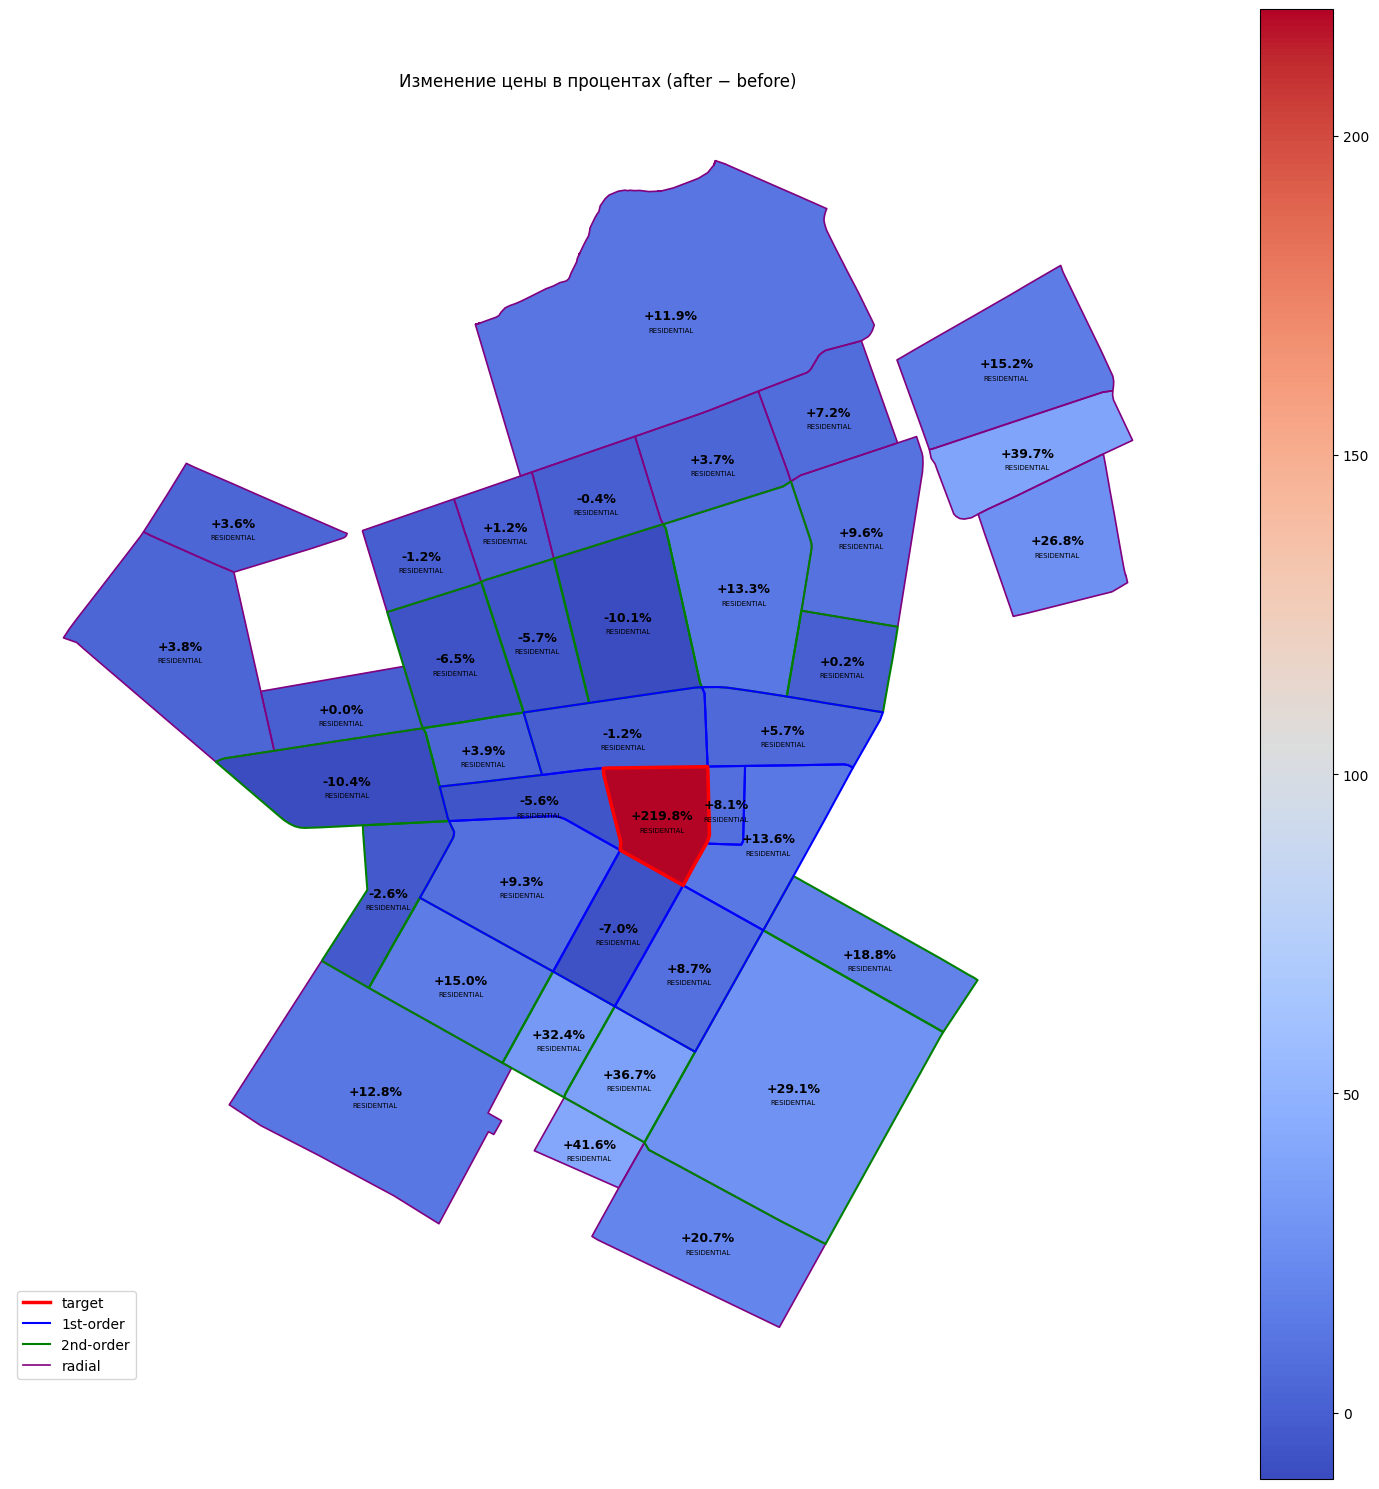

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import lag_spatial
from matplotlib.lines import Line2D
from matplotlib.transforms import offset_copy

def plot_scenario_with_types_highlight_target(
    blocks, w1, w2, wR, model,
    orig_feats, numeric_feats,
    target_idx, changes
):
    """
    Визуализация Δ log_total_price для target и соседей,
    с разметкой по типу соседства и явным выделением target.
    Сравниваем предсказания ДО и ПОСЛЕ «what-if», выводим изменение в процентах.
    """
    # 0) Подготовка индексов соседей
    ids1 = sorted(w1.neighbors[target_idx])
    ids2 = sorted(set(w2.neighbors[target_idx]) - set(ids1))
    idsR = sorted(set(wR.neighbors[target_idx]) - set(ids1) - set(ids2))
    idxs = [target_idx] + ids1 + ids2 + idsR

    # 1) Базовые данные и лаги
    blocks_base = blocks.copy()
    lag_cols = []
    gm = blocks_base[numeric_feats].mean()
    for feat in numeric_feats:
        vec = blocks_base[feat].fillna(gm[feat])
        for prefix, w in (('lag1', w1), ('lag2', w2), ('lagR', wR)):
            col = f'{prefix}_{feat}'
            blocks_base[col] = lag_spatial(w, vec)
            lag_cols.append(col)
    blocks_base['n1'] = pd.Series({i: len(nb) for i, nb in w1.neighbors.items()})
    blocks_base['n2'] = pd.Series({i: len(nb) for i, nb in w2.neighbors.items()})
    blocks_base['nR'] = pd.Series({i: len(nb) for i, nb in wR.neighbors.items()})
    lag_cols += ['n1', 'n2', 'nR']

    all_feats = orig_feats + lag_cols

    X_before = blocks_base.loc[idxs, all_feats].copy()
    X_before['land_use'] = X_before['land_use'].fillna('missing').astype(str).astype('category')
    X_before['morphotype'] = X_before['morphotype'].fillna(False).astype('bool').astype('category')
    preds_before = model.predict(X_before)

    # 2) Применяем изменения
    blocks_scn = blocks_base.copy()
    for feat, newval in changes.items():
        blocks_scn.at[target_idx, feat] = newval

    for feat in numeric_feats:
        vec = blocks_scn[feat].fillna(gm[feat])
        for prefix, w in (('lag1', w1), ('lag2', w2), ('lagR', wR)):
            col = f'{prefix}_{feat}'
            blocks_scn[col] = lag_spatial(w, vec)

    X_after = blocks_scn.loc[idxs, all_feats].copy()
    X_after['land_use'] = X_after['land_use'].fillna('missing').astype(str).astype('category')
    X_after['morphotype'] = X_after['morphotype'].fillna(False).astype('bool').astype('category')
    preds_after = model.predict(X_after)

    # 3) GeoDataFrame с расчетами
    gdf = blocks.loc[idxs].copy()
    gdf['pred_before'] = preds_before
    gdf['pred_after'] = preds_after
    gdf['log_diff'] = gdf['pred_after'] - gdf['pred_before']
    gdf['pct_change'] = (np.exp(gdf['log_diff']) - 1) * 100

    # 4) Текстовый отчет
    def ntype(i):
        if i == target_idx: return 'target'
        if i in ids1: return '1st-order'
        if i in ids2: return '2nd-order'
        return 'radial'

    print("Δ цены в процентах (после − до):")
    for i, r in gdf.iterrows():
        print(
            f" • {i} ({ntype(i)}): "
            f"{r['pred_before']:.3f} → {r['pred_after']:.3f} "
            f"(Δ {r['log_diff']:+.3f} log, {r['pct_change']:+.1f}%)"
        )

    # 5) Визуализация
    fig, ax = plt.subplots(figsize=(15, 15))
    gdf.plot(
        ax=ax, column='pct_change', cmap='coolwarm', legend=True,
        edgecolor='none', zorder=1
    )
    for i in idsR:
        gdf.loc[[i]].boundary.plot(ax=ax, color='purple', linewidth=1.2, zorder=2)
    for i in ids2:
        gdf.loc[[i]].boundary.plot(ax=ax, color='green', linewidth=1.5, zorder=3)
    for i in ids1:
        gdf.loc[[i]].boundary.plot(ax=ax, color='blue', linewidth=1.5, zorder=4)
    gdf.loc[[target_idx]].plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2.5, zorder=5)

    ax.axis('off')
    ax.set_title('Изменение цены в процентах (after − before)', pad=12)

    legend_elems = [
        Line2D([0], [0], color='red', lw=2.5, label='target'),
        Line2D([0], [0], color='blue', lw=1.5, label='1st-order'),
        Line2D([0], [0], color='green', lw=1.5, label='2nd-order'),
        Line2D([0], [0], color='purple', lw=1.2, label='radial'),
    ]
    ax.legend(handles=legend_elems, loc='lower left')

    # 6) Подписи проценты и land_use
    for i, r in gdf.iterrows():
        x, y = r.geometry.centroid.coords[0]
        # % изменение
        ax.text(
            x, y, f"{r['pct_change']:+.1f}%",
            ha='center', va='center',
            fontsize=9, fontweight='bold', zorder=6
        )
        # land_use под %
        ax.text(
            x, y,
            str(r['land_use']),
            ha='center', va='center',
            fontsize=5, color='black', zorder=6,
            transform=offset_copy(ax.transData, fig=fig, y=-10, units='points')
        )

    plt.tight_layout()
    plt.show()


plot_scenario_with_types_highlight_target(
    blocks=blocks,
    w1=w1, w2=w2, wR=wR,
    model=model,
    orig_feats=feature_cols,
    numeric_feats=numeric_feats,
    target_idx=33,
    changes={
        'footprint_area': 49039.24,
        'build_floor_area': 230279.19,
        'living_area': 155896.85,
        'population': 5168,
        'fsi': 2.80,
        'mxi': 0.68,
        'l': 6.93,
        'share_living': 4.69
    }
)


# CatBoost 2 

/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

0:	learn: 2.1715708	test: 2.1836800	best: 2.1836800 (0)	total: 5.42ms	remaining: 43.3s
100:	learn: 1.1165118	test: 1.1510768	best: 1.1510768 (100)	total: 306ms	remaining: 23.9s
200:	learn: 1.0134796	test: 1.1047494	best: 1.1047494 (200)	total: 597ms	remaining: 23.2s
300:	learn: 0.9389279	test: 1.0859272	best: 1.0859272 (300)	total: 851ms	remaining: 21.8s
400:	learn: 0.8850376	test: 1.0770429	best: 1.0770064 (396)	total: 1.2s	remaining: 22.7s
500:	learn: 0.8355156	test: 1.0715354	best: 1.0713871 (495)	total: 1.51s	remaining: 22.6s
600:	learn: 0.7943354	test: 1.0658657	best: 1.0657020 (599)	total: 1.8s	remaining: 22.2s
700:	learn: 0.7604034	test: 1.0627923	best: 1.0625691 (698)	total: 2.1s	remaining: 21.9s
800:	learn: 0.7308306	test: 1.0603582	best: 1.0603405 (799)	total: 2.39s	remaining: 21.5s
900:	learn: 0.7025681	test: 1.0597636	best: 1.0594644 (894)	total: 2.71s	remaining: 21.4s
1000:	learn: 0.6773905	test: 1.0573631	best: 1.0570610 (995)	total: 3.08s	remaining: 21.5s
Stopped by over

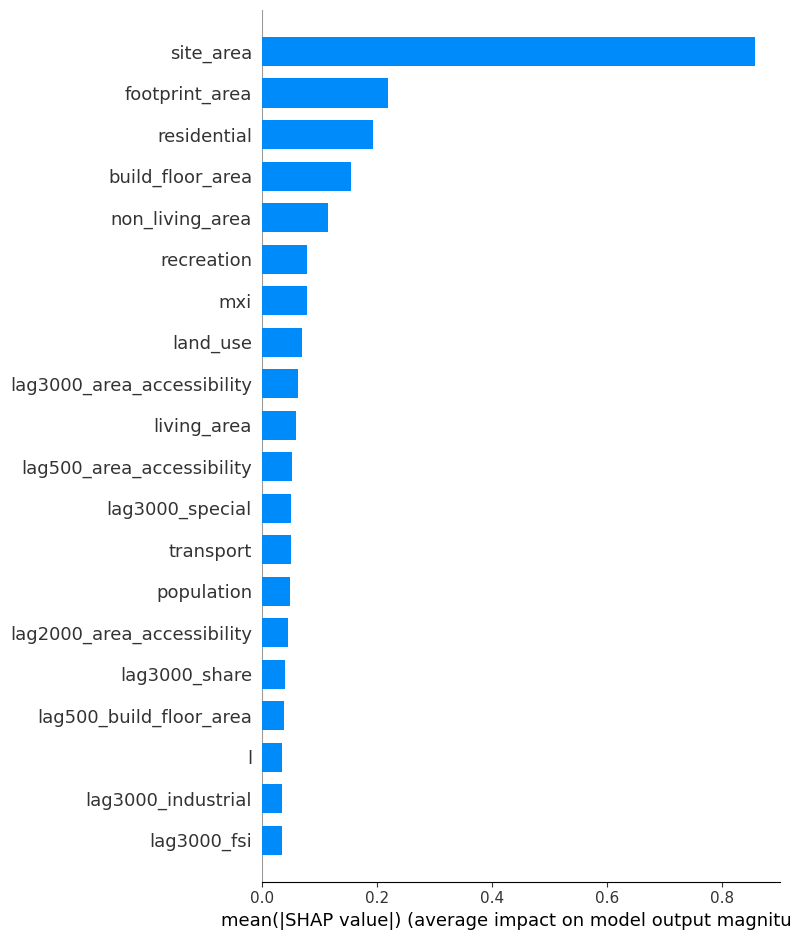

<Figure size 640x480 with 0 Axes>

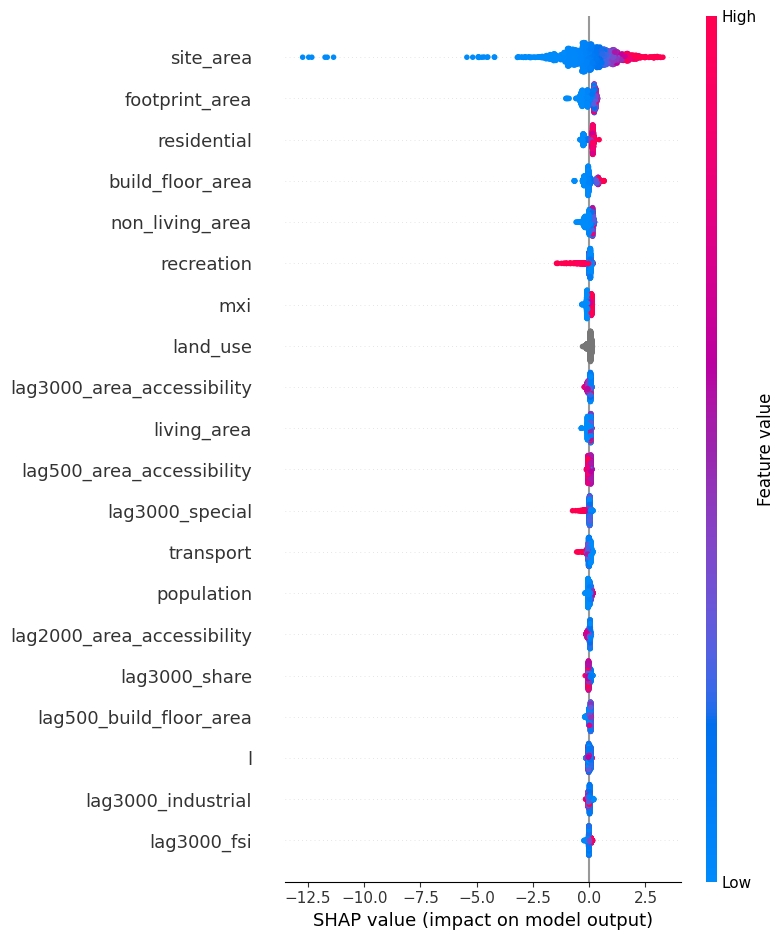

<Figure size 640x480 with 0 Axes>

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt
from libpysal.weights import DistanceBand, lag_spatial

# --- 0. Исходные данные ---
# feature_cols = [
#     'land_use', 'share',
#     'footprint_area', 'build_floor_area', 'living_area', 'non_living_area',
#     'population', 'site_area', 'fsi', 'gsi', 'mxi', 'l', 'osr',
#     'share_living', 'share_non_living', 'morphotype', 'area_accessibility',
#     'residential', 'business', 'recreation', 'industrial',
#     'transport', 'special', 'agriculture'
# ]

feature_cols =  [
    'residential', 'business', 'recreation', 'industrial',
    'transport', 'special', 'agriculture', 'land_use', 'share',
     'footprint_area','build_floor_area', 'living_area', 'non_living_area', 'population',
    'site_area', 'fsi', 'gsi', 'mxi', 'l', 'morphotype',
    'area_accessibility'
]


cat_feats = ['land_use', 'morphotype']
numeric_feats = [c for c in feature_cols if c not in cat_feats]

# --- 1. Радиальные матрицы соседства ---
radius_list = [300, 500, 1000, 2000, 3000]
w_radii = {}
for r in radius_list:
    w = DistanceBand.from_dataframe(
        blocks, threshold=r, binary=True, silence_warnings=True
    )
    w.transform = 'r'  # нормализация строк
    w_radii[r] = w

# --- 2. Генерация лаг-фичей по радиусам ---
lag_cols = []
for feat in numeric_feats:
    vec = blocks[feat].fillna(blocks[feat].mean())
    for r in radius_list:
        col_name = f'lag{r}_{feat}'
        blocks[col_name] = lag_spatial(w_radii[r], vec)
        lag_cols.append(col_name)

# (опционально) число соседей по каждому радиусу
for r in radius_list:
    n_col = f'n_neighbors_{r}'
    blocks[n_col] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
    lag_cols.append(n_col)

# --- 3. Финальный список фичей и train/test split ---
all_feats = feature_cols + lag_cols
X = blocks[all_feats]
y = blocks['log_total_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 4. Предобработка категориальных фичей ---
cat_features = ['land_use', 'morphotype']
for df in (X_train, X_test):
    df['land_use'] = df['land_use'].fillna('missing').astype(str).astype('category')
    df['morphotype'] = df['morphotype'].fillna('missing').astype(str).astype('category')

cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_features]

# --- 5. Pool для CatBoost ---
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_feature_indices)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_feature_indices)

# --- 6. Обучение модели ---
model = CatBoostRegressor(
    iterations=8000,
    learning_rate=0.05,
    depth=5,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

# --- 7. Оценка на тесте ---
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²   = {r2:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

# --- 8. SHAP-анализ ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 8.1 Глобальная важность
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.tight_layout()
plt.show()

# 8.2 Beeswarm
shap.summary_plot(shap_values, X_test)
plt.tight_layout()
plt.show()


In [44]:
model.save_model('catboost_model.cbm')

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import lag_spatial
from matplotlib.lines import Line2D
from matplotlib.transforms import offset_copy

def plot_scenario_with_radii(
    blocks, w_radii, model,
    orig_feats, numeric_feats,
    target_idx, changes
):
    """
    Визуализация Δ log_total_price для target и соседей по радиусам,
    с разметкой и выводом изменения в процентах.
    """
    radius_list = sorted(w_radii.keys())  # например [100,500,1000,2000,3000]

    # 0) Подготовка индексов соседей по каждому радиусу
    radius_ids = {}
    prev_ids = set()
    for r in radius_list:
        ids = set(w_radii[r].neighbors.get(target_idx, []))
        # исключаем всё, что уже попало в меньшие радиусы
        ids = ids - prev_ids
        radius_ids[r] = sorted(ids)
        prev_ids |= ids

    # Составляем итоговый список всех индексов
    idxs = [target_idx] + [i for r in radius_list for i in radius_ids[r]]

    # 1) Базовые данные и лаги
    blocks_base = blocks.copy()
    lag_cols = []
    gm = blocks_base[numeric_feats].mean()

    for feat in numeric_feats:
        vec = blocks_base[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_base[col] = lag_spatial(w_radii[r], vec)
            lag_cols.append(col)

    # Число соседей по каждому радиусу
    for r in radius_list:
        ncol = f'n_neighbors_{r}'
        blocks_base[ncol] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
        lag_cols.append(ncol)

    all_feats = orig_feats + lag_cols

    # 2) Признаки до изменений
    X_before = blocks_base.loc[idxs, all_feats].copy()
    X_before['land_use'] = X_before['land_use'].fillna('missing').astype(str).astype('category')
    X_before['morphotype'] = X_before['morphotype'].fillna(False).astype('bool').astype('category')
    preds_before = model.predict(X_before)

    # 3) Применяем изменения
    blocks_scn = blocks_base.copy()
    for feat, newval in changes.items():
        blocks_scn.at[target_idx, feat] = newval

    for feat in numeric_feats:
        vec = blocks_scn[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_scn[col] = lag_spatial(w_radii[r], vec)

    X_after = blocks_scn.loc[idxs, all_feats].copy()
    X_after['land_use'] = X_after['land_use'].fillna('missing').astype(str).astype('category')
    X_after['morphotype'] = X_after['morphotype'].fillna(False).astype('bool').astype('category')
    preds_after = model.predict(X_after)

    # 4) GeoDataFrame с расчетами
    # gdf = blocks.loc[idxs].copy()
    gdf = blocks_scn.loc[idxs].copy()
    gdf['pred_before'] = preds_before
    gdf['pred_after'] = preds_after
    gdf['log_diff'] = gdf['pred_after'] - gdf['pred_before']
    gdf['pct_change'] = (np.exp(gdf['log_diff']) - 1) * 100

    # 5) Текстовый отчет
    def ntype(i):
        if i == target_idx:
            return 'target'
        for r in radius_list:
            if i in radius_ids[r]:
                return f'radius_{r}m'
        return 'other'

    print("Δ цены в процентах (после − до):")
    for i, r in gdf.iterrows():
        print(
            f" • {i} ({ntype(i)}): "
            f"{r['pred_before']:.3f} → {r['pred_after']:.3f} "
            f"(Δ {r['log_diff']:+.3f} log, {r['pct_change']:+.1f}%)"
        )

    # 6) Сводная статистика по радиусам
    stats = []
    for r in radius_list:
        ids = radius_ids[r]
        if ids:
            mean_pct = gdf.loc[ids, 'pct_change'].mean()
            std_pct = gdf.loc[ids, 'pct_change'].std()
            stats.append((r, mean_pct, std_pct, len(ids)))
        else:
            stats.append((r, np.nan, np.nan, 0))

    print("\nСреднее изменение цены по радиусам:")
    for r, m, s, n in stats:
        print(f" • Радиус {r}м: среднее {m:+.1f}%, std {s:.1f}, участков {n}")

    # ————— добавляем вывод итогового среднего —————
    # собираем всех соседей во всех радиусах
    all_neighbor_ids = [i for r in radius_list for i in radius_ids[r]]
    if all_neighbor_ids:
        overall_mean = gdf.loc[all_neighbor_ids, 'pct_change'].mean()
        overall_std = gdf.loc[all_neighbor_ids, 'pct_change'].std()
        total_n = len(all_neighbor_ids)
        print(f"\nИтоговое среднее изменение цены по всем соседям: "
              f"{overall_mean:+.1f}% (std {overall_std:.1f}%, участков {total_n})")
    else:
        print("\nНет соседей для расчёта итогового среднего.")


    # 7) Визуализация
    fig, ax = plt.subplots(figsize=(25, 25))
    gdf.plot(
        ax=ax, column='pct_change', cmap='coolwarm', legend=True,
        edgecolor='none', zorder=1
    )

    colors = ['blue', 'green', 'orange', 'purple', 'brown']
    for color, r in zip(colors, radius_list):
        ids = radius_ids[r]
        if ids:
            gdf.loc[ids].boundary.plot(ax=ax, color=color, linewidth=1.5, zorder=3)

    # Целевой участок
    gdf.loc[[target_idx]].plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2.5, zorder=4)

    ax.axis('off')
    ax.set_title('Изменение цены в процентах (after − before)', pad=12)

    legend_elems = [
        Line2D([0], [0], color='red', lw=2.5, label='target'),
    ] + [
        Line2D([0], [0], color=c, lw=1.5, label=f'radius {r}m') for c, r in zip(colors, radius_list)
    ]
    ax.legend(handles=legend_elems, loc='lower left')

    # 8) Подписи
    for i, r in gdf.iterrows():
        x, y = r.geometry.centroid.coords[0]
        ax.text(
            x, y, f"{r['pct_change']:+.1f}%",
            ha='center', va='center',
            fontsize=9, fontweight='bold', zorder=6
        )
        ax.text(
            x, y,
            str(r['land_use']),
            ha='center', va='center',
            fontsize=5, color='black', zorder=6,
            transform=offset_copy(ax.transData, fig=fig, y=-10, units='points')
        )

    plt.tight_layout()
    plt.show()


Δ цены в процентах (после − до):
 • 33 (target): 19.826 → 20.735 (Δ +0.909 log, +148.2%)
 • 5410 (radius_300m): 17.247 → 17.303 (Δ +0.056 log, +5.8%)
 • 5415 (radius_300m): 15.289 → 15.390 (Δ +0.102 log, +10.7%)
 • 3810 (radius_500m): 21.954 → 21.982 (Δ +0.028 log, +2.8%)
 • 5370 (radius_500m): 20.179 → 20.168 (Δ -0.011 log, -1.1%)
 • 5411 (radius_500m): 19.307 → 19.338 (Δ +0.030 log, +3.1%)
 • 45 (radius_1000m): 21.262 → 21.285 (Δ +0.023 log, +2.3%)
 • 46 (radius_1000m): 20.161 → 20.187 (Δ +0.026 log, +2.6%)
 • 53 (radius_1000m): 21.699 → 21.687 (Δ -0.012 log, -1.2%)
 • 56 (radius_1000m): 20.051 → 20.040 (Δ -0.010 log, -1.0%)
 • 281 (radius_1000m): 15.310 → 15.398 (Δ +0.088 log, +9.2%)
 • 1170 (radius_1000m): 16.203 → 16.244 (Δ +0.042 log, +4.3%)
 • 5340 (radius_1000m): 17.461 → 17.516 (Δ +0.055 log, +5.6%)
 • 5341 (radius_1000m): 21.024 → 21.060 (Δ +0.035 log, +3.6%)
 • 5346 (radius_1000m): 18.335 → 18.314 (Δ -0.020 log, -2.0%)
 • 5347 (radius_1000m): 20.526 → 20.507 (Δ -0.019 log, -

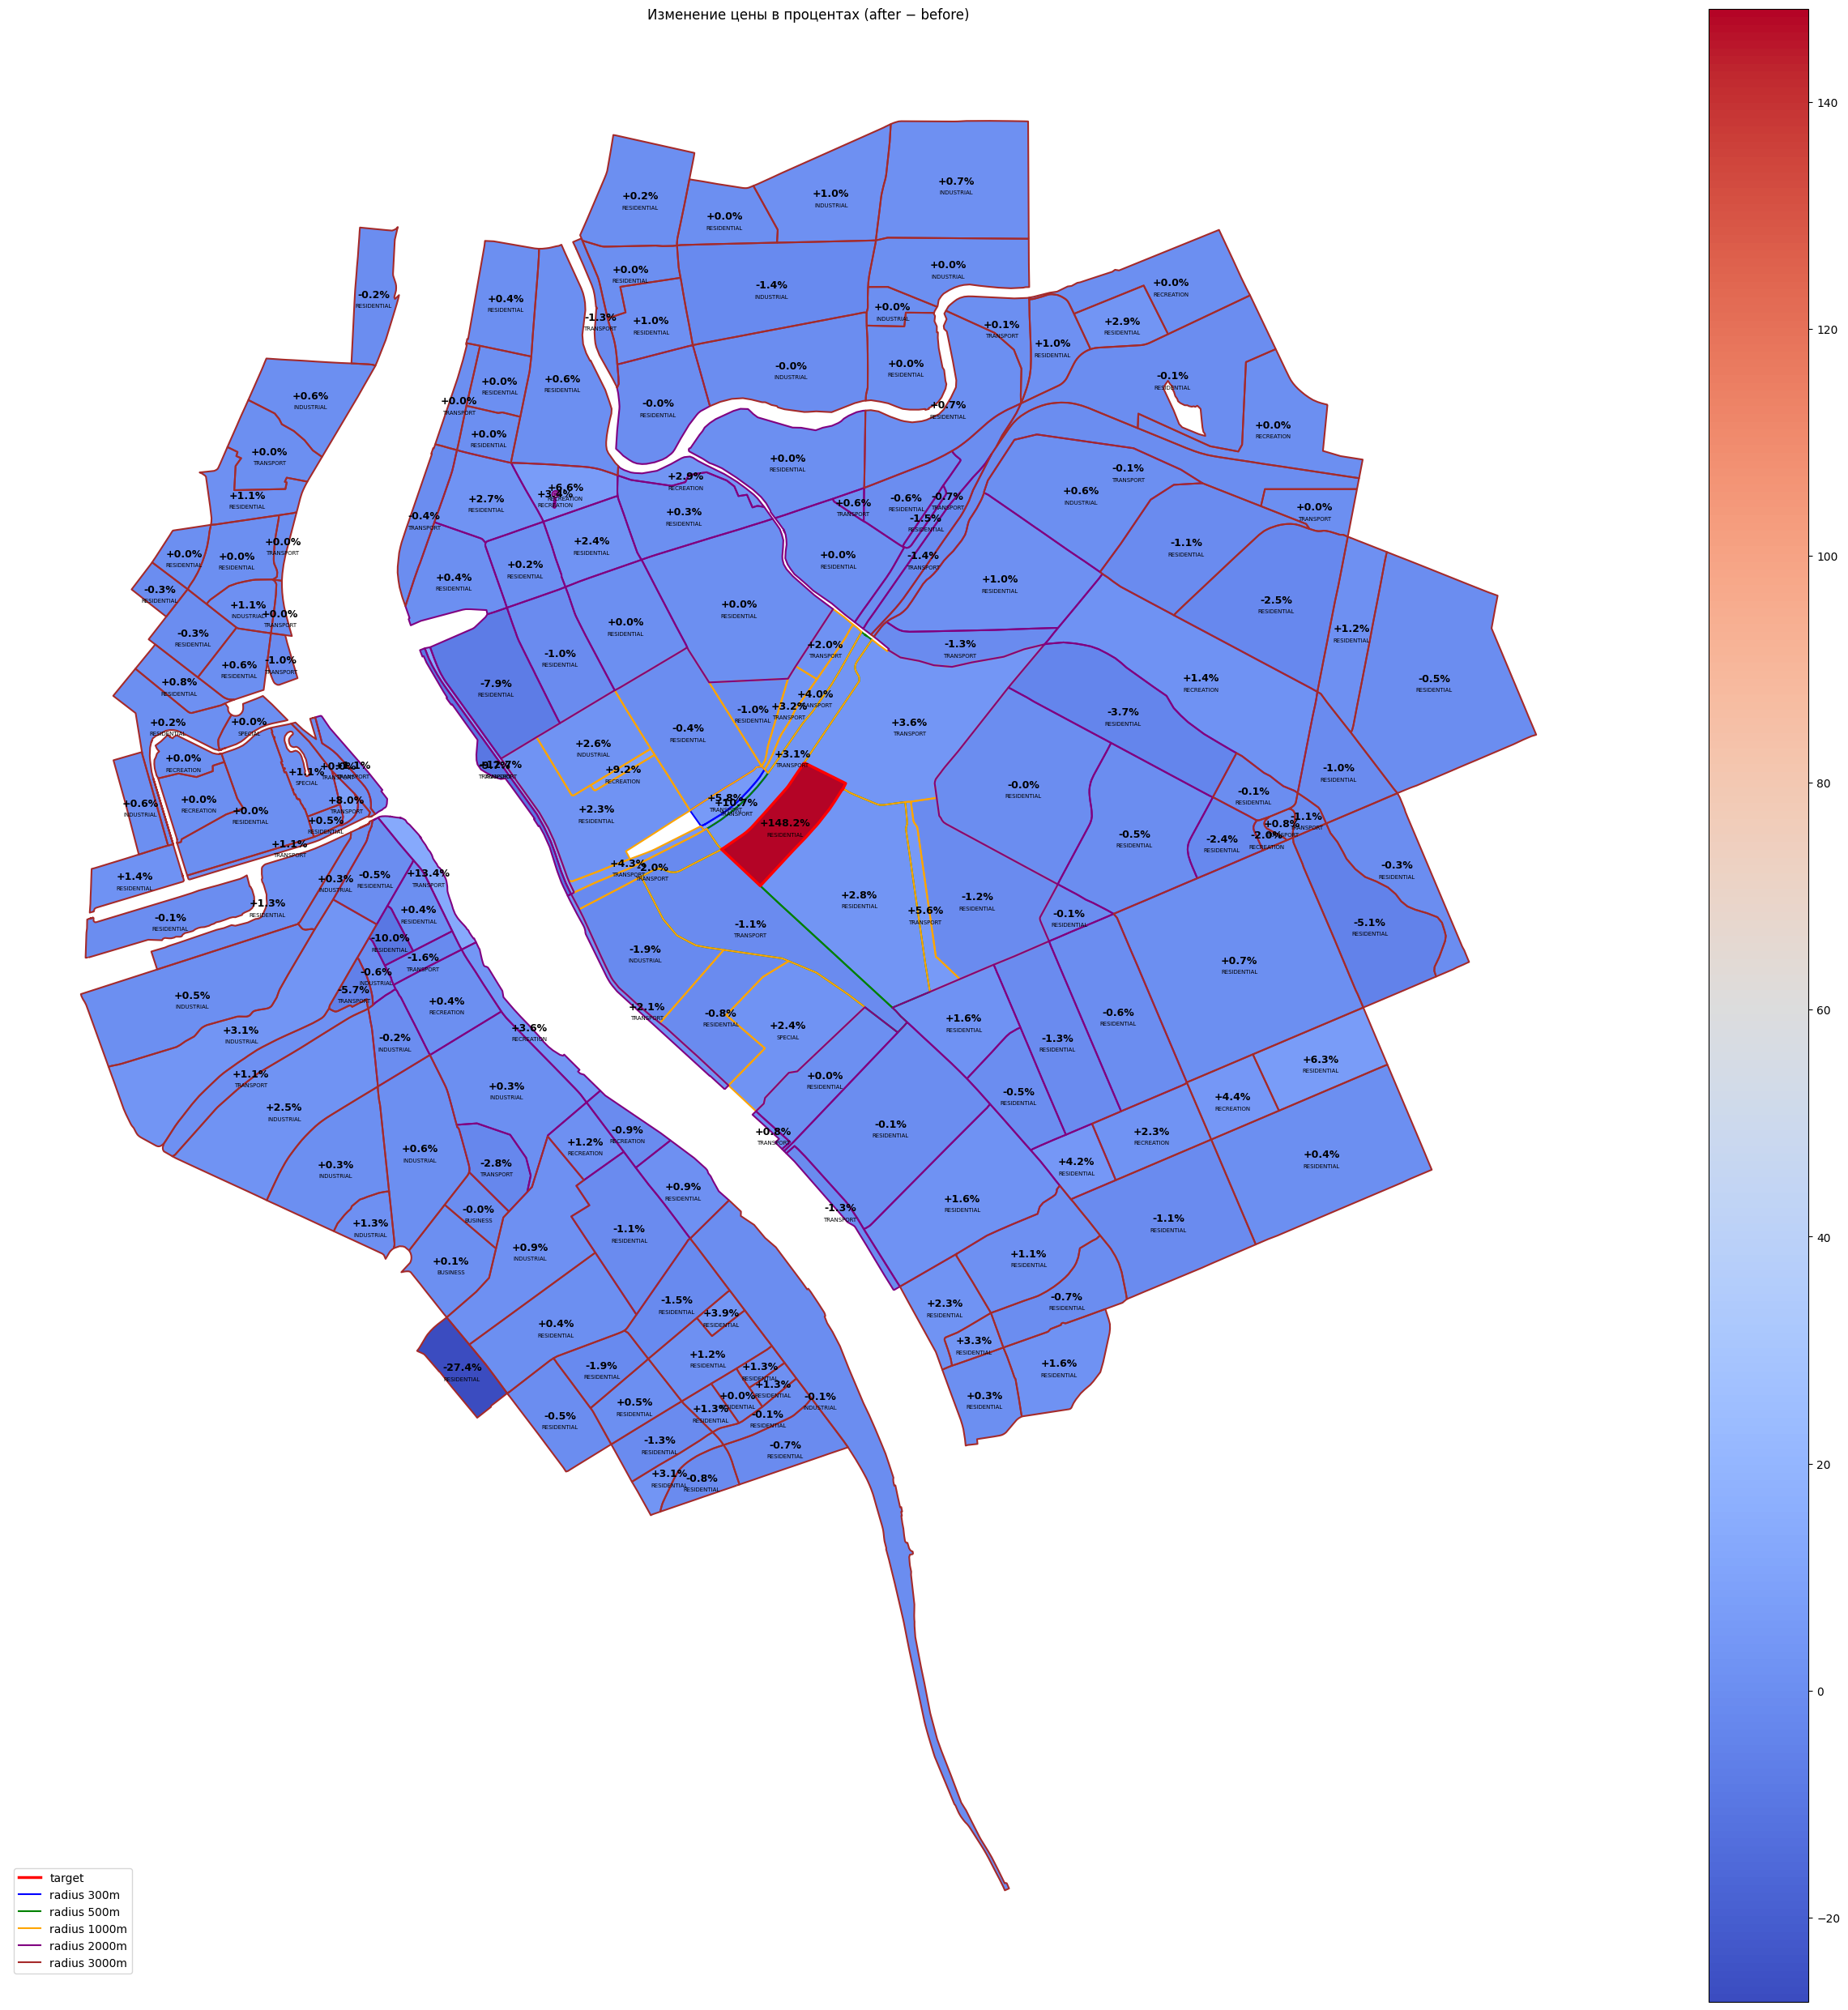

In [51]:
plot_scenario_with_radii(
    blocks=blocks,
    w_radii=w_radii,          # это словарь {100: w100, 500: w500, ...}
    model=model,
    orig_feats=feature_cols,
    numeric_feats=numeric_feats,
    target_idx=33,
    changes={
        'land_use': 'RESIDENTIAL',
        'share': 0.95,
        'footprint_area': 49039.24,
        'build_floor_area': 230279.19,
        'living_area': 155896.85,
        'population': 5168,
        'fsi': 2.80,
        'mxi': 0.68,
        'l': 6.93,
        'osr': 0.21,
        'share_living': 4.69
    }
)
